In [2]:
import math
import random
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np

from JavaClones.Vec2 import Vec2
from Plotting.Plotter import PlotType, Plotter
from Simulating.SimConfig import SimConfig
from Simulating.SimStep import SimStep2d
from Simulating.Simulator import Simulator


In [3]:
v_max = 2.0
a_max = 3.0

global_save_figures = False


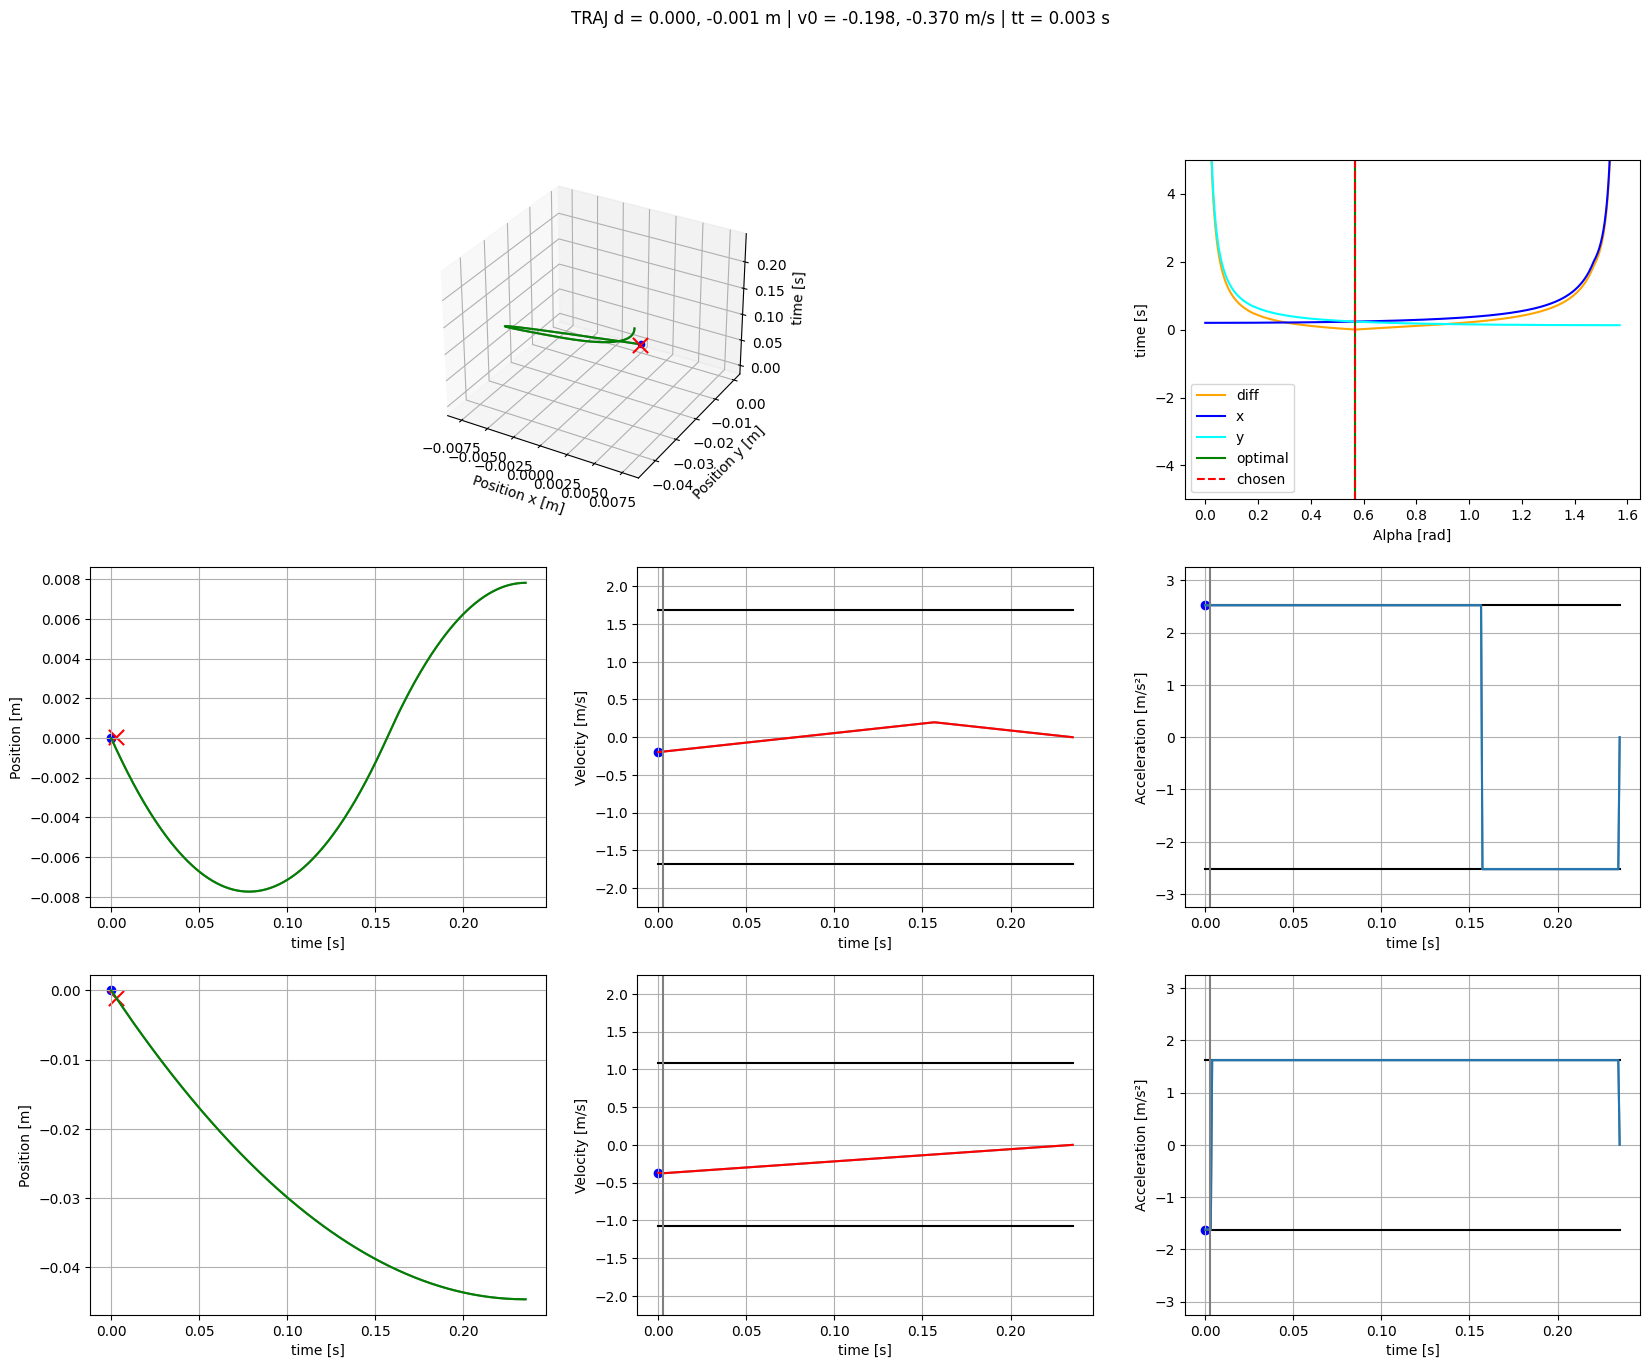

In [7]:
pos = Vec2(-1.500045805093028095100748942058999091386795043945312500000000, -2.998924883609135783046895085135474801063537597656250000000000)
des = Vec2(-1.5, -3)
v0 = Vec2(-0.197649899153979929922186897783831227570772171020507812500000, -0.370221239935862311831726856325985863804817199707031250000000)
tt = 2.4 -  2.397213821051999094180473548476584255695343017578125000000000

Plotter.plot(
    s0=pos,
    s1=des,
    v0=v0,
    v_max=v_max,
    a_max=a_max,
    tt=tt,
    primary_direction=None,
    plot_type=PlotType.TRAJ,
    save_fig=False,
    show_fig=True
)


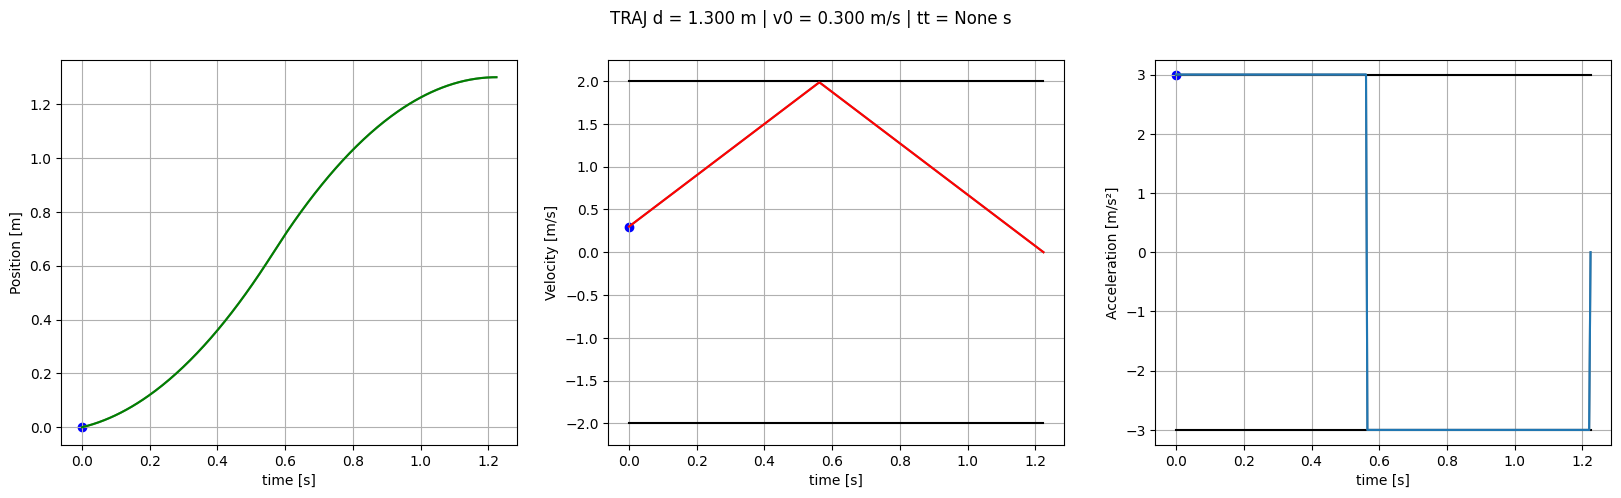

In [4]:
Plotter.plot(
    s0=0.2,
    s1=1.5,
    v0=0.3,
    v_max=v_max,
    a_max=a_max,
    tt=None,
    primary_direction=None,
    plot_type=PlotType.TRAJ,
    save_fig=False,
    show_fig=True
)

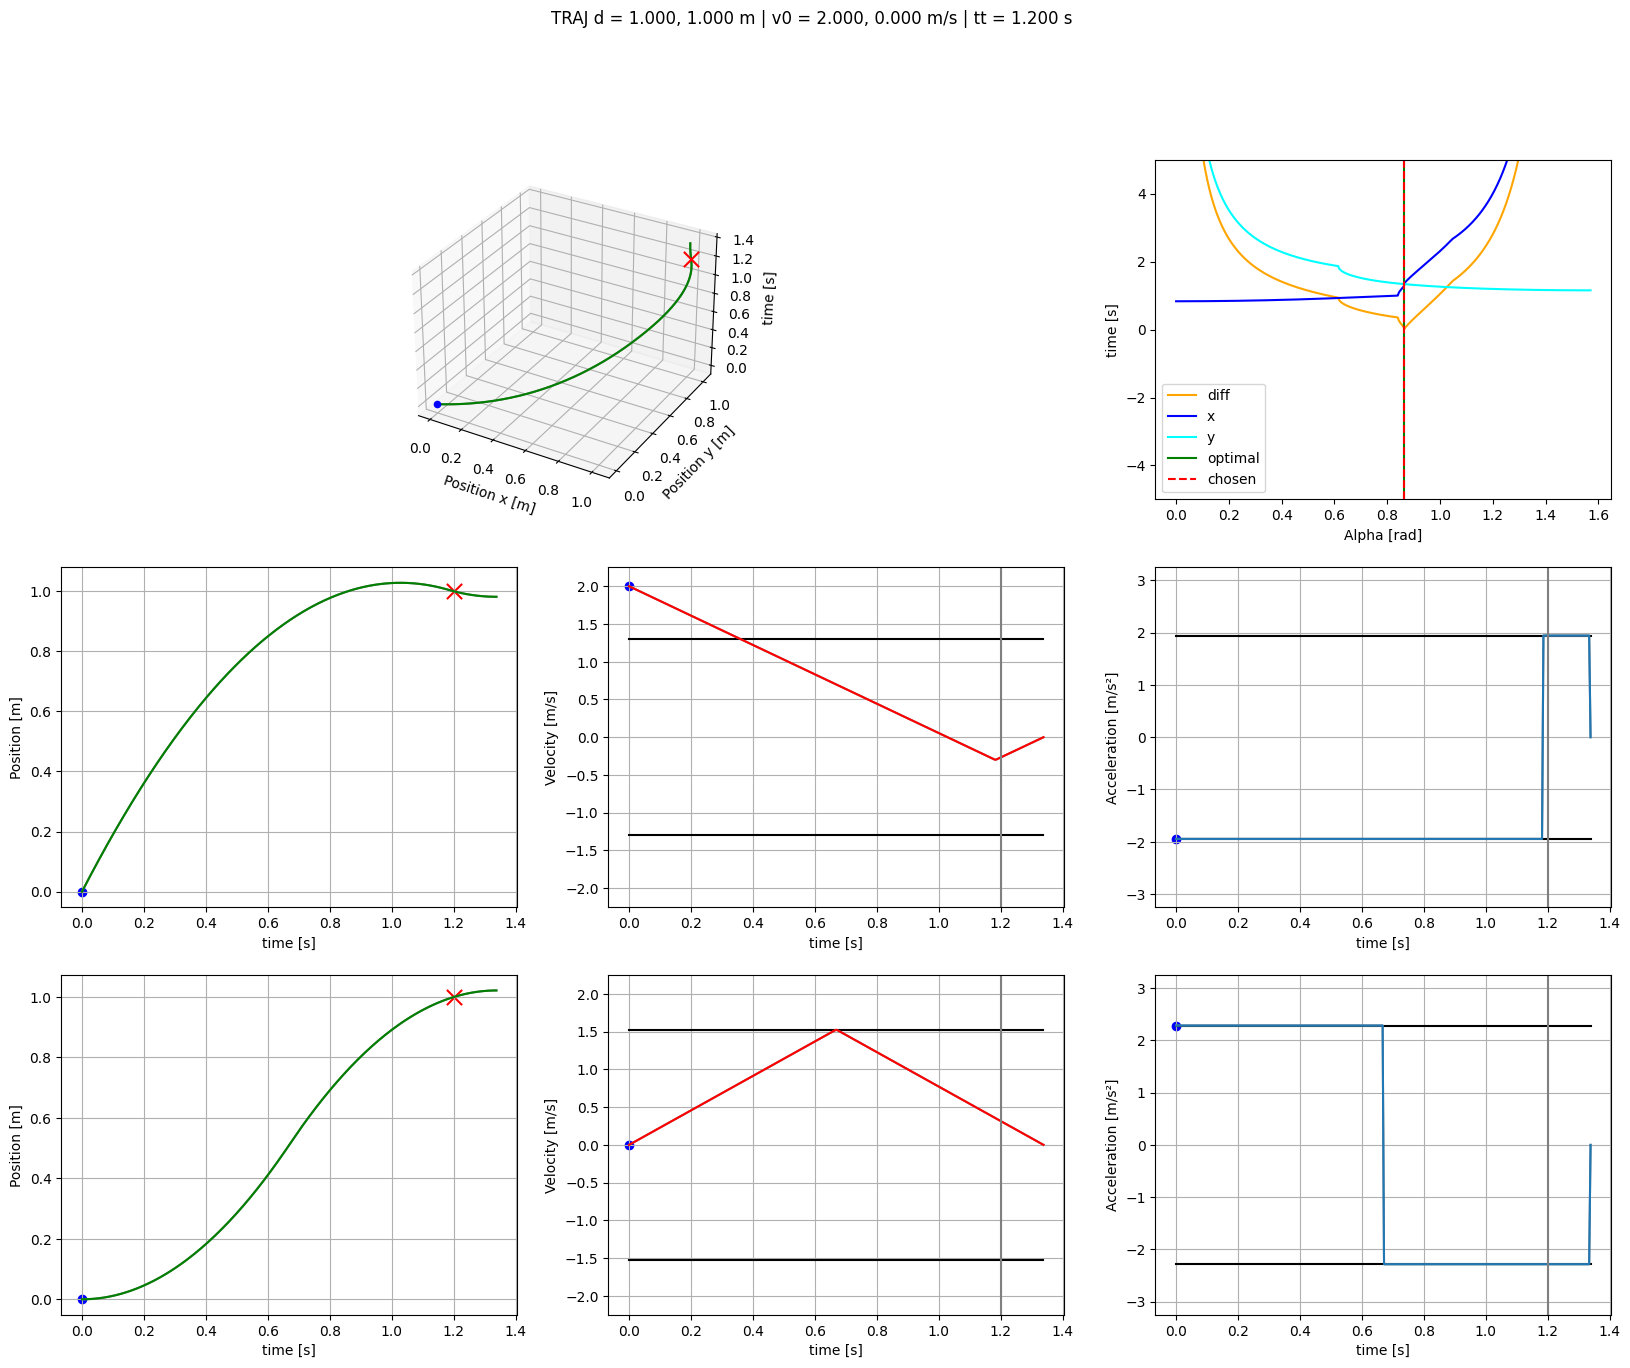

In [5]:
Plotter.plot(
    s0=Vec2.zero(),
    s1=Vec2(1.0, 1.0),
    v0=Vec2(v_max, 0.0),
    v_max=v_max,
    a_max=a_max,
    tt=1.2,
    primary_direction=None,
    plot_type=PlotType.TRAJ,
    save_fig=False,
    show_fig=True
)

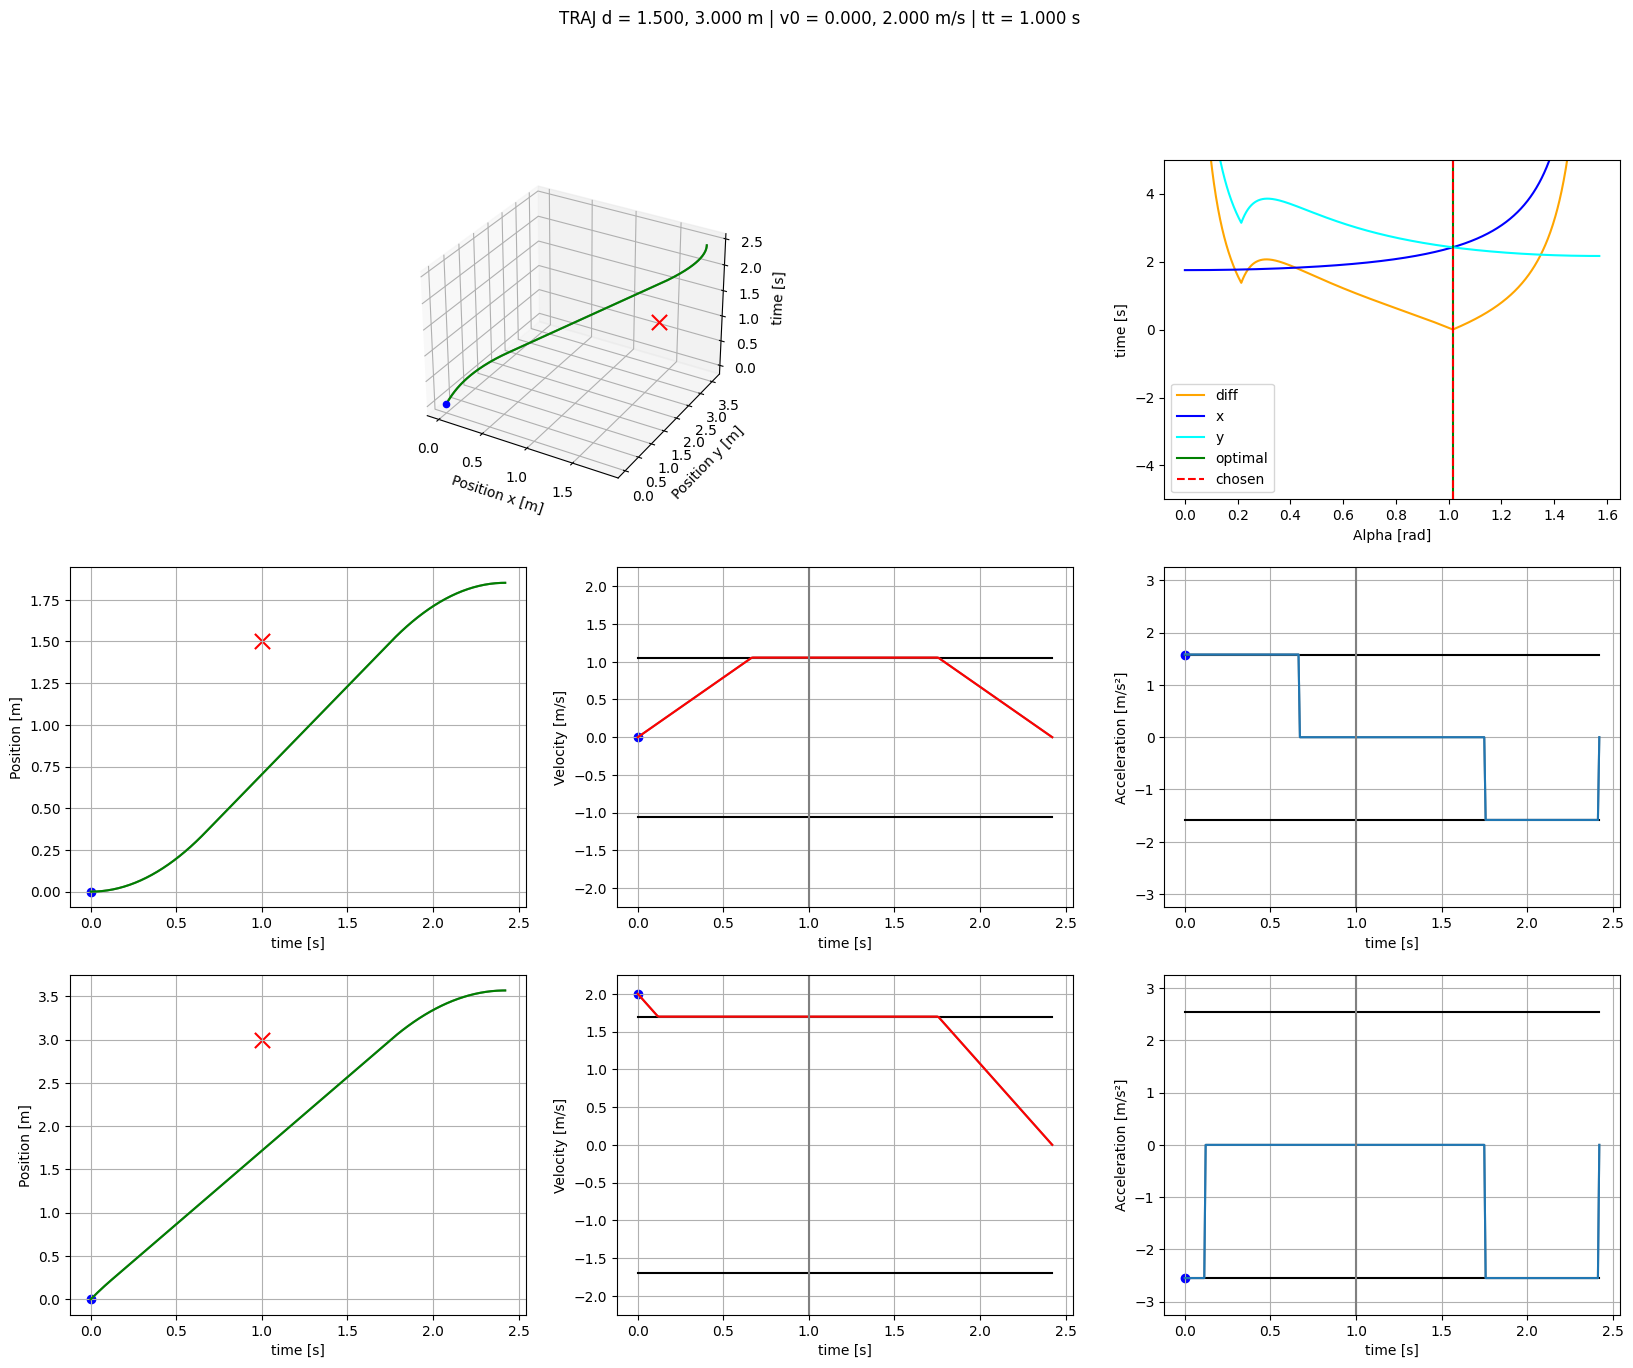

In [6]:
distances = [Vec2(1.5, 3)]
initial_velocities = [Vec2(0, 2)]
target_times = [1]

for d in sorted(set(distances)):
    for i_v in sorted(set(initial_velocities)):
        for tt in sorted(set(target_times)):
            Plotter.plot(
                s0=Vec2.zero(),
                s1=d,
                v0=i_v,
                v_max=v_max,
                a_max=a_max,
                tt=tt,
                primary_direction=None,
                plot_type=PlotType.TRAJ,
                save_fig=False,
                show_fig=True
            )

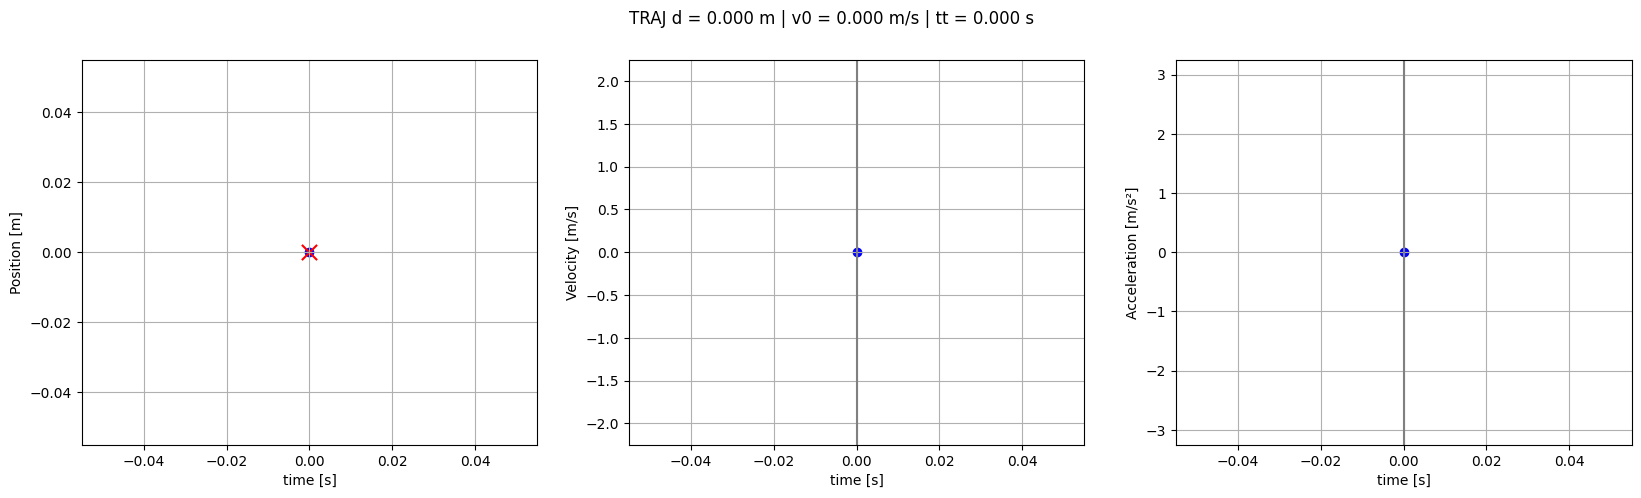

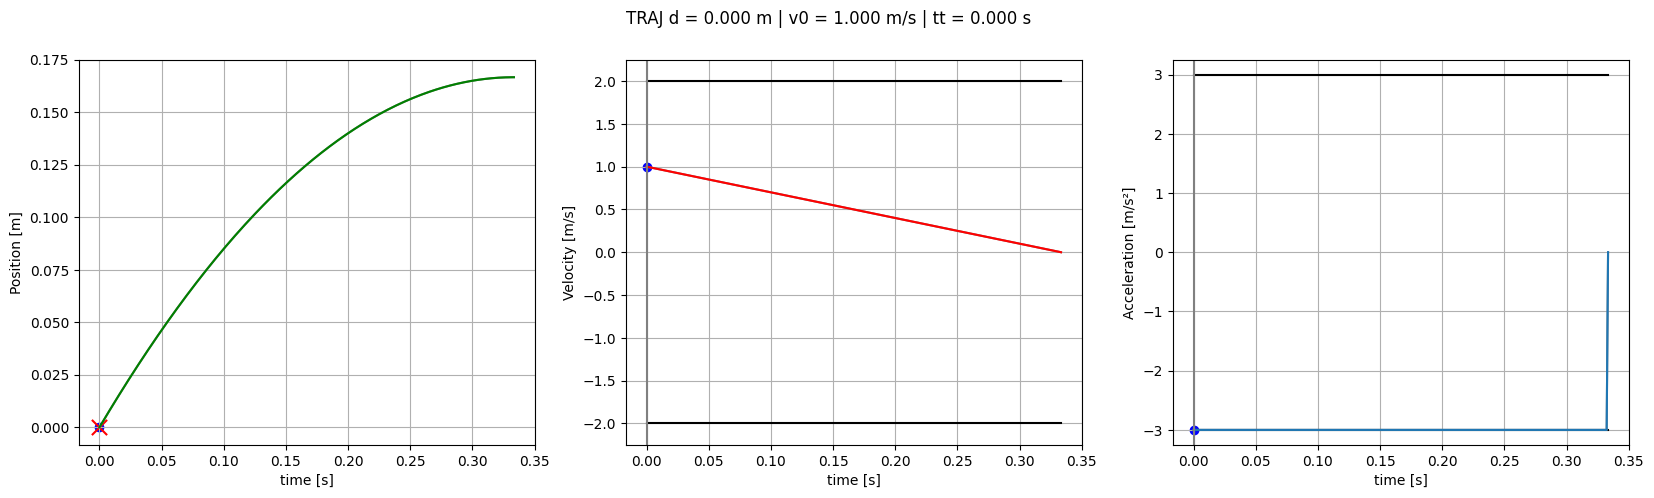

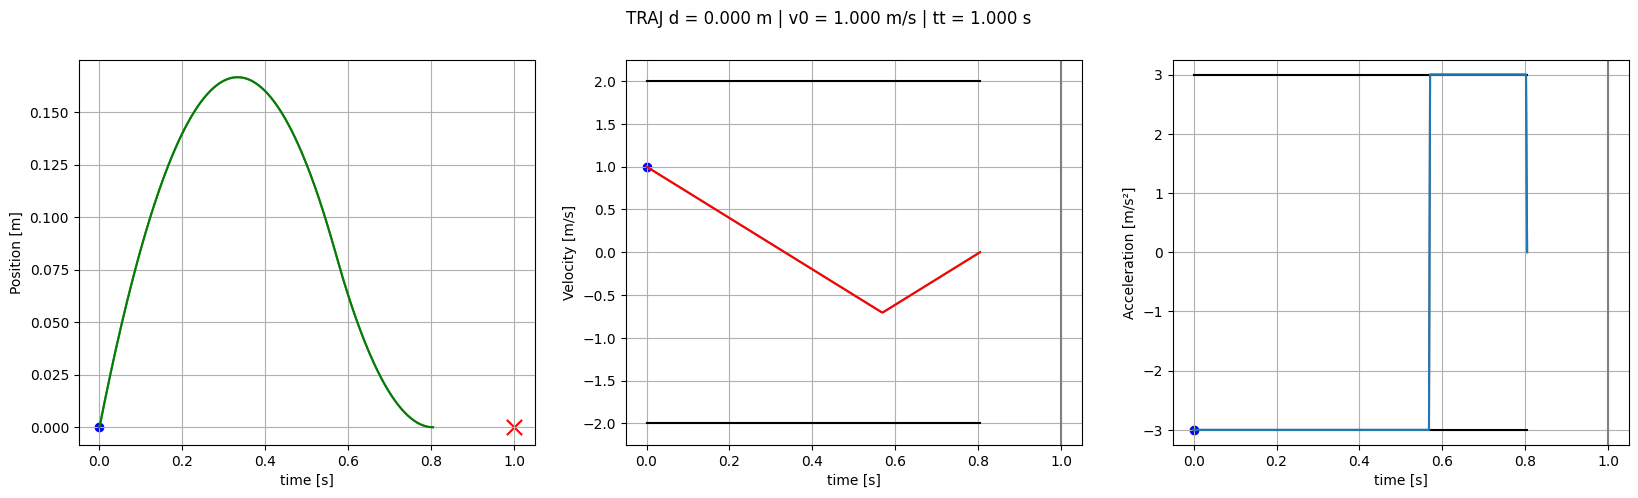

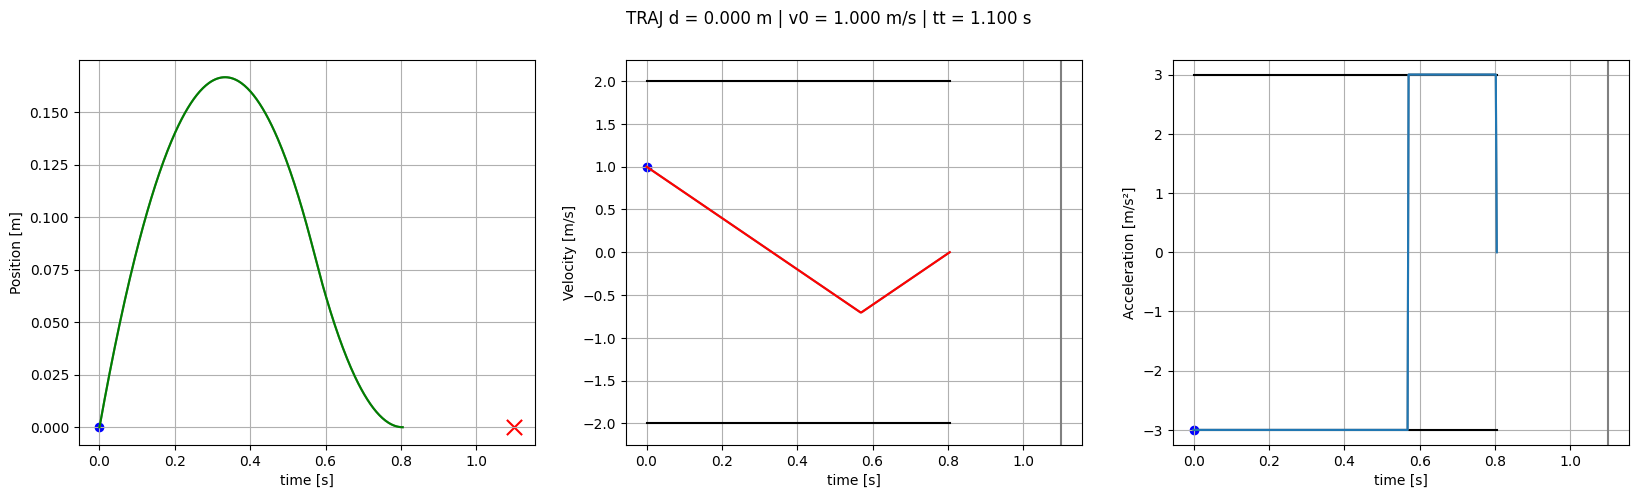

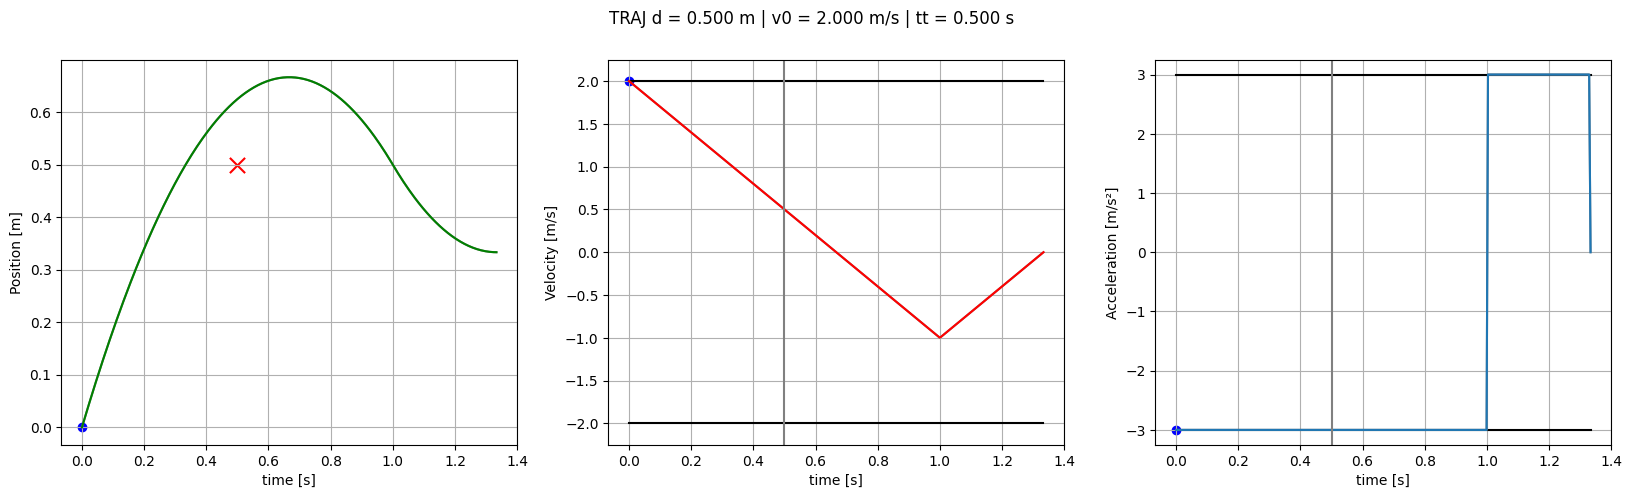

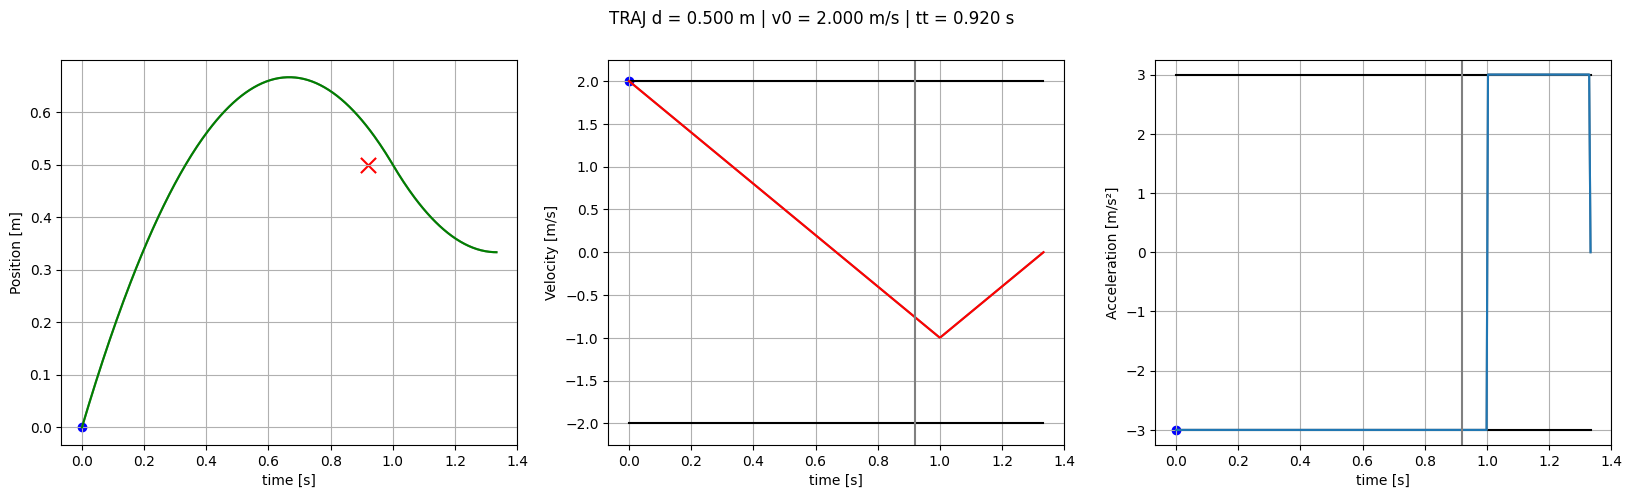

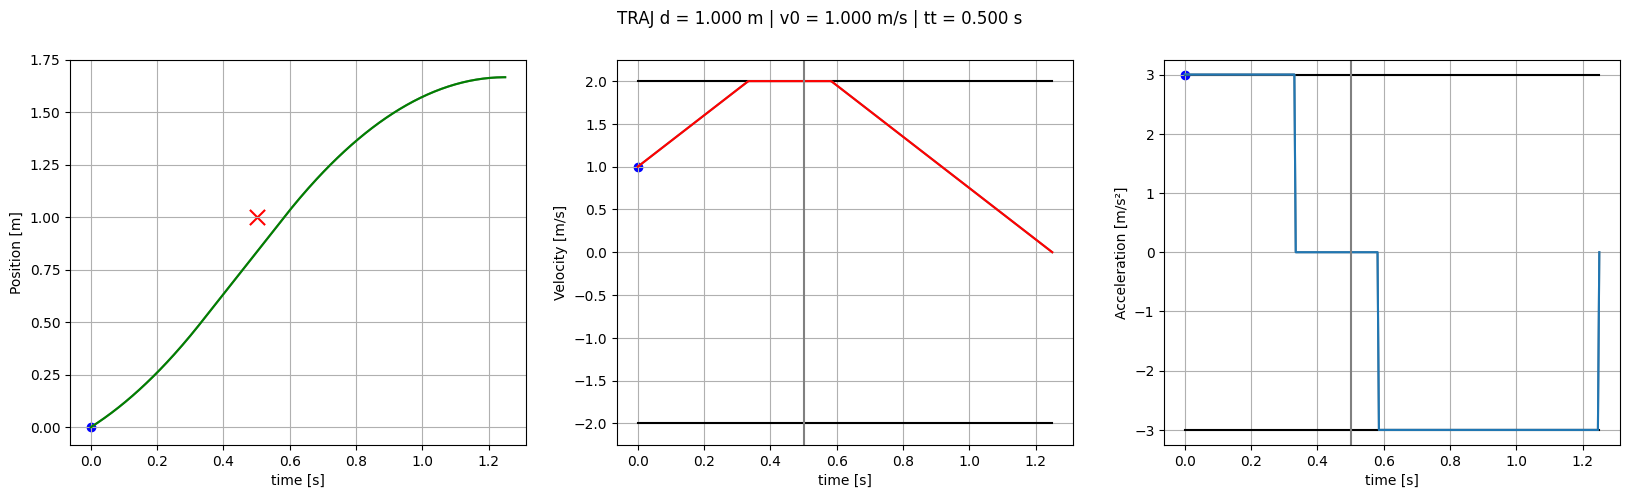

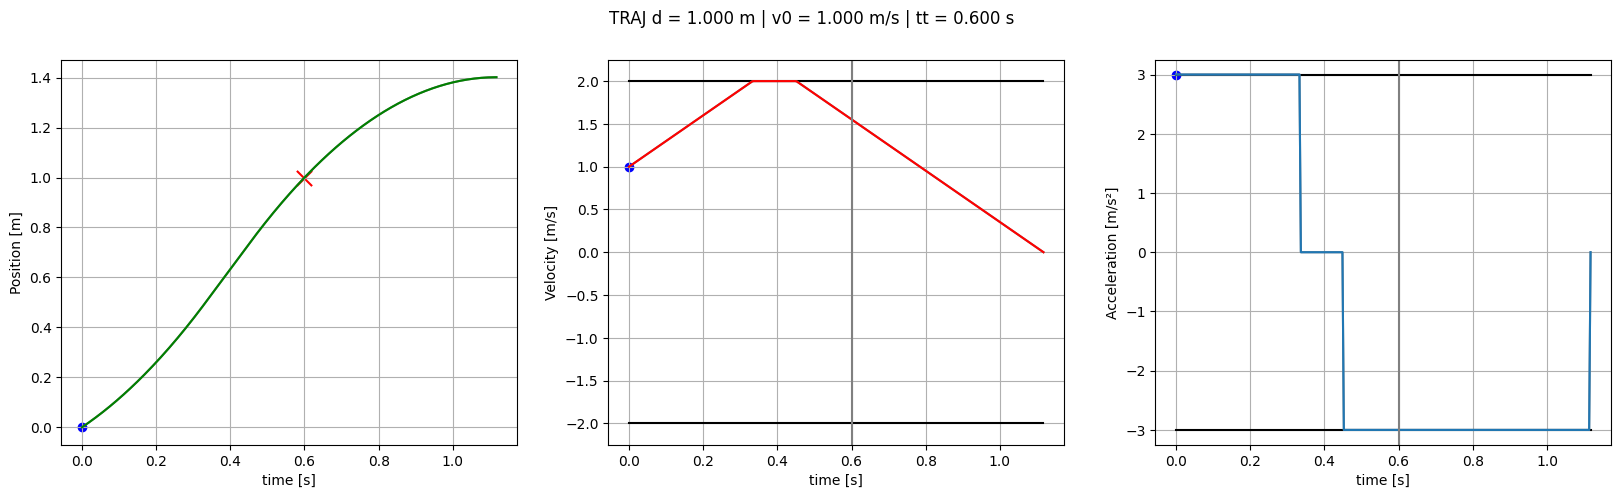

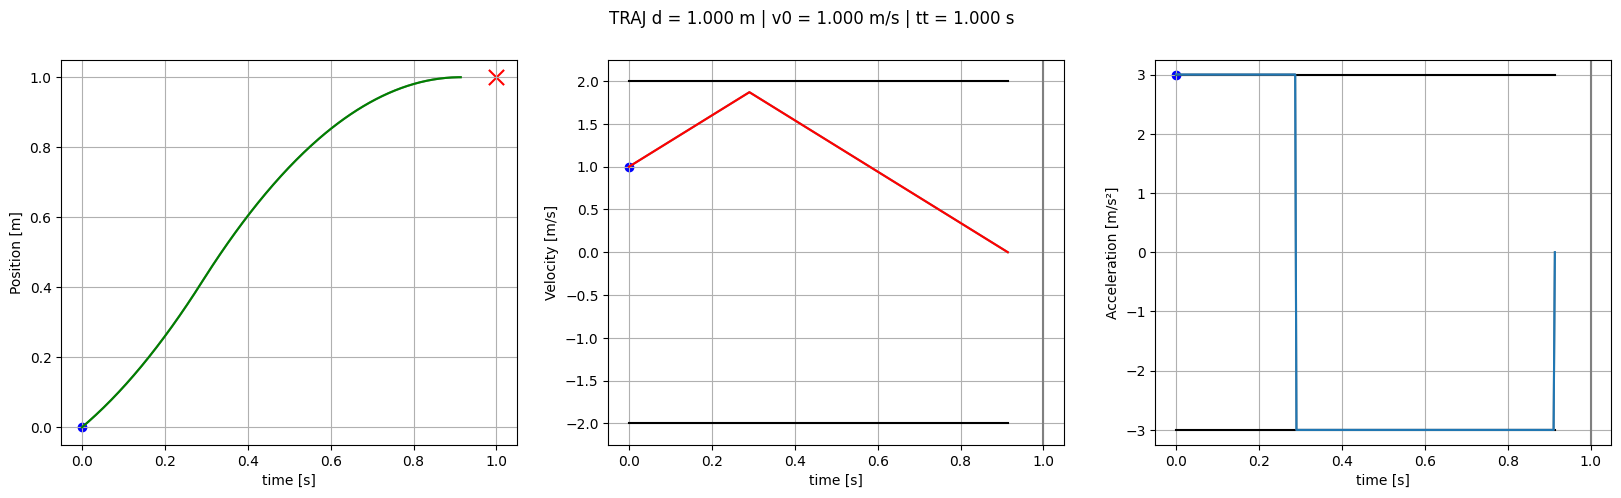

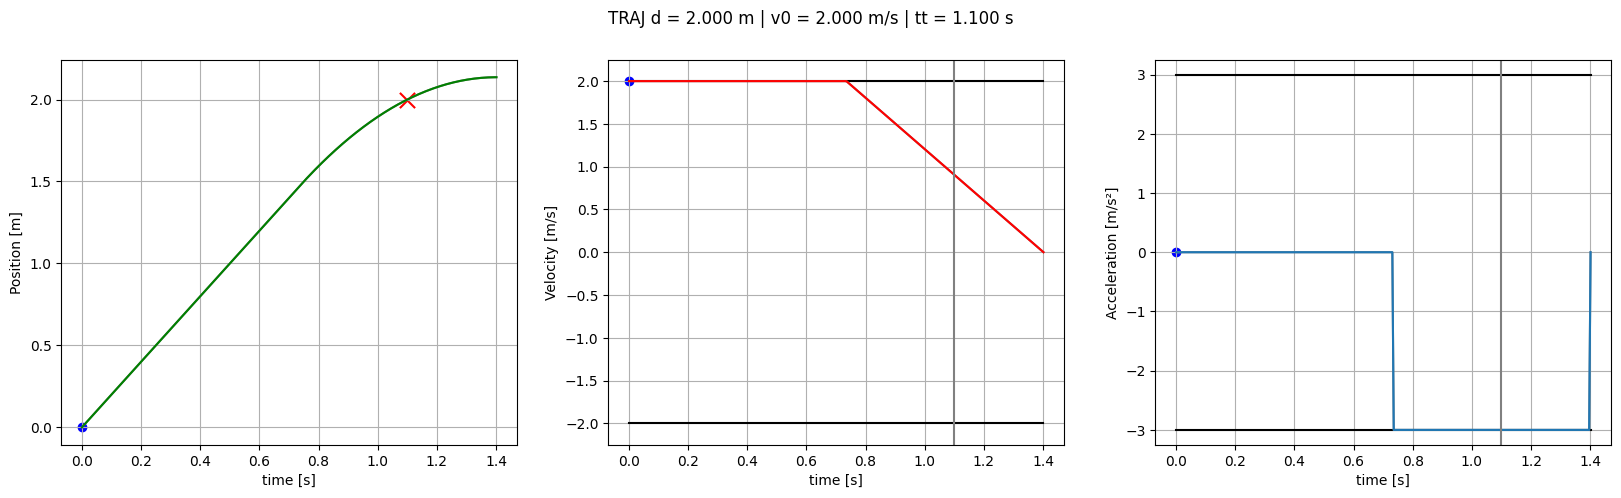

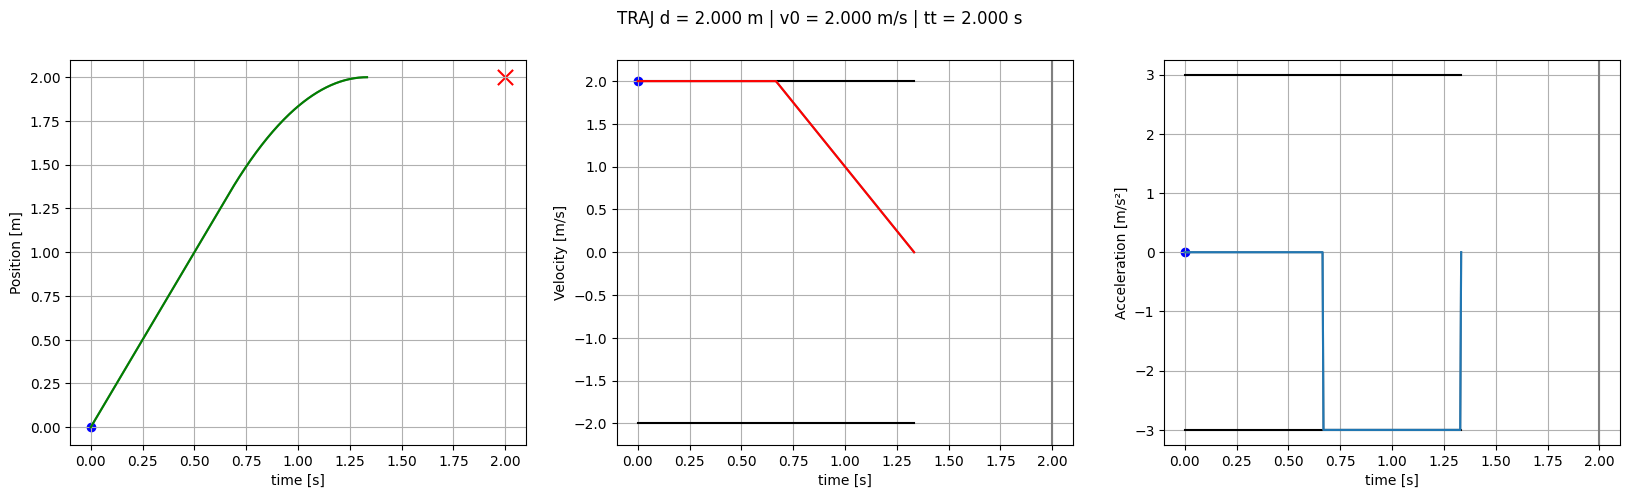

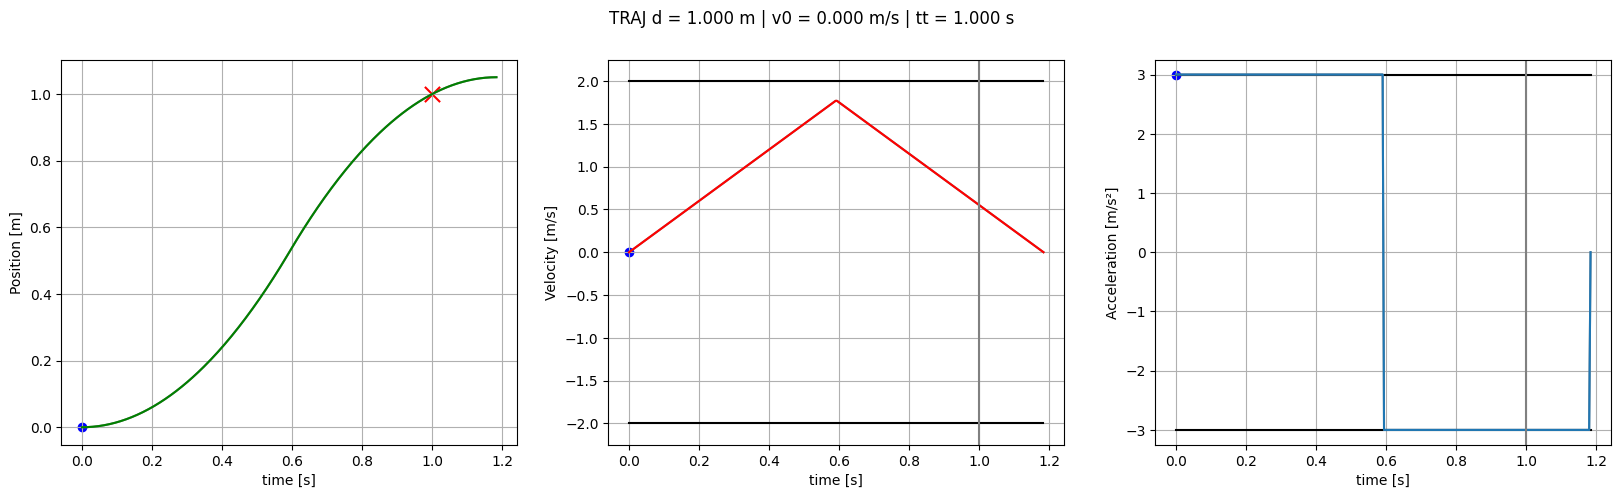

In [7]:
test_values = [
    (0.0, 0.0, 0.0),
    (0.0, 1.0, 0.0),
    (0.0, 1.0, 1.0),
    (0.0, 1.0, 1.1),
    (0.5, 2.0, 0.5),
    (0.5, 2.0, 0.92),
    (1.0, 1.0, 0.5),
    (1.0, 1.0, 0.6),
    (1.0, 1.0, 1.0),
    (2.0, 2.0, 1.1),
    (2.0, 2.0, 2.0),
    (1.0, 0.0, 1.0),
]

for values in test_values:
    Plotter.plot(
        s0=0,
        s1=values[0],
        v0=values[1],
        v_max=v_max,
        a_max=a_max,
        tt=values[2],
        primary_direction=None,
        plot_type=PlotType.TRAJ,
        save_fig=False,
        show_fig=True
    )

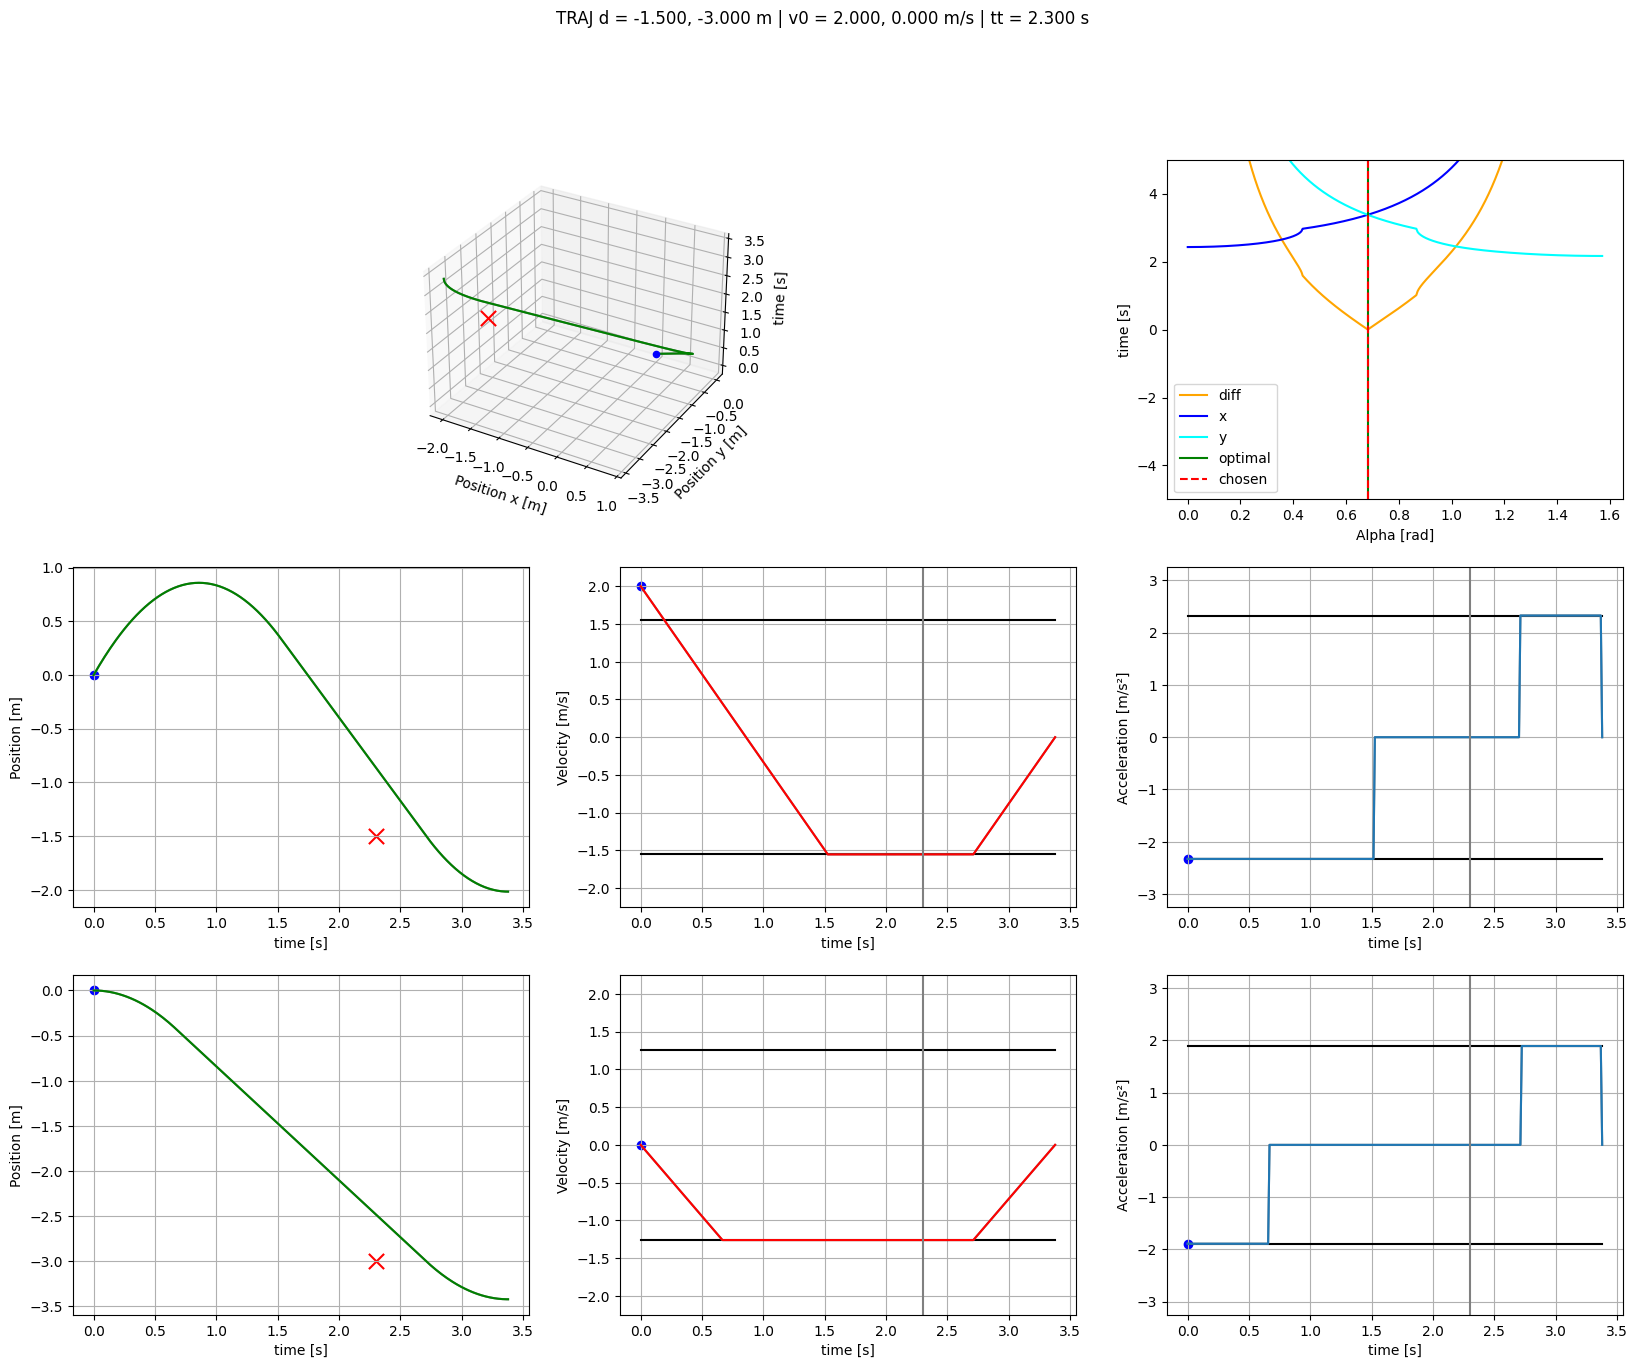

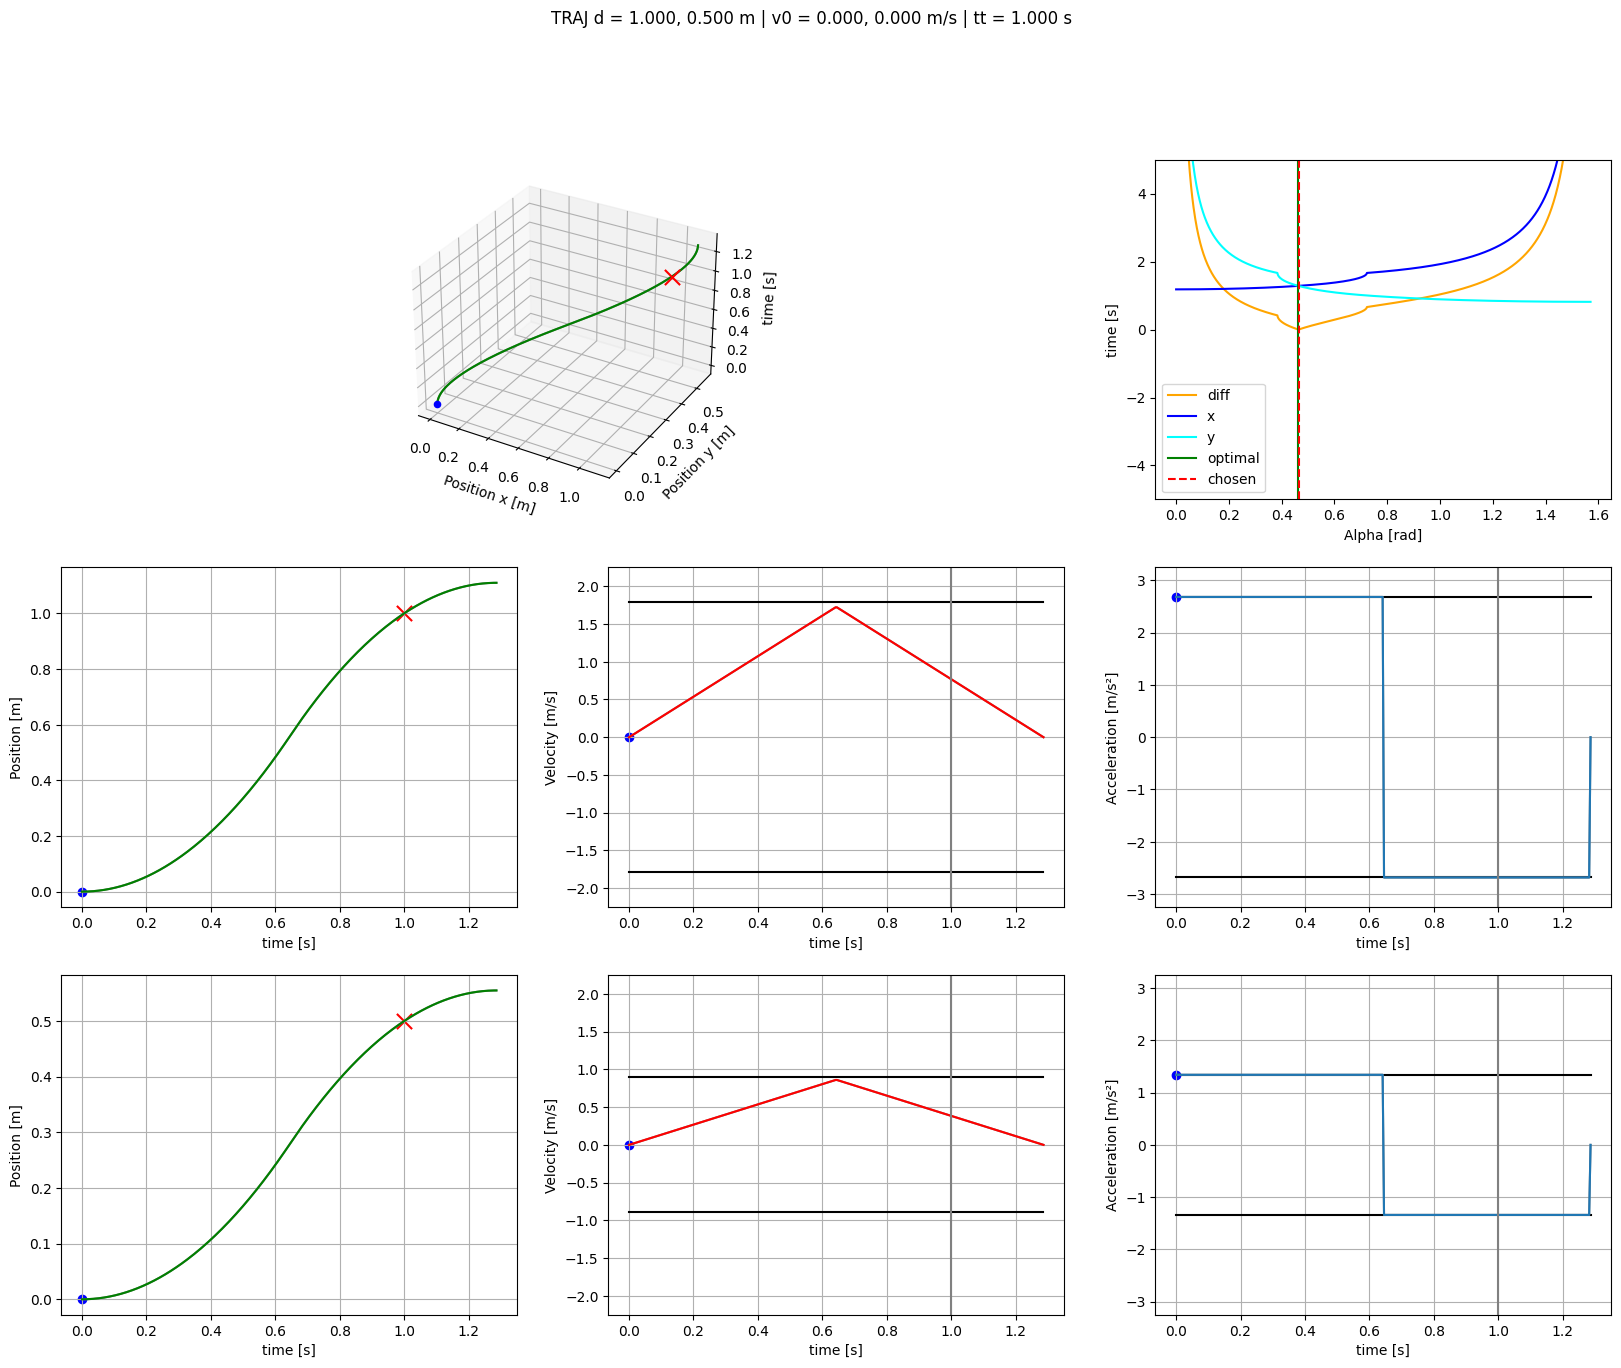

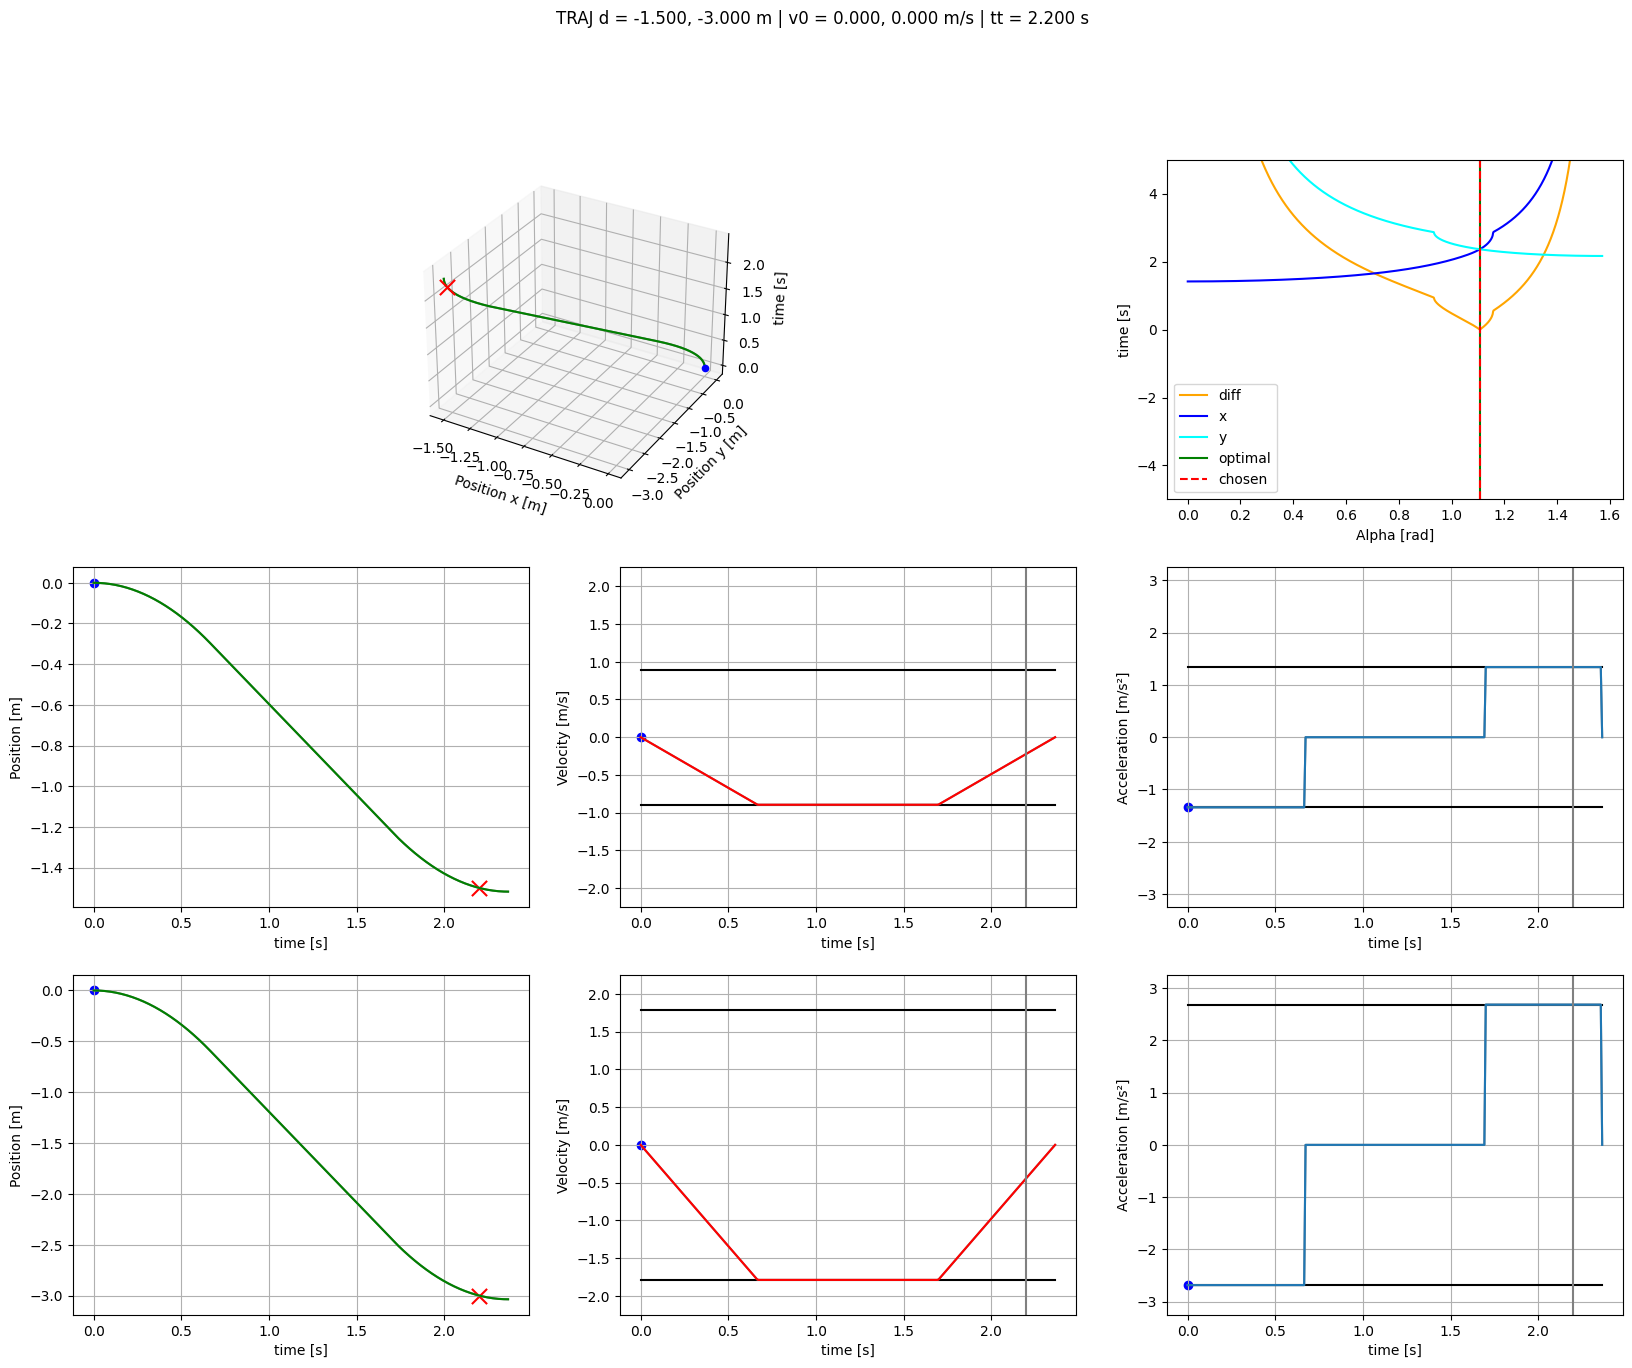

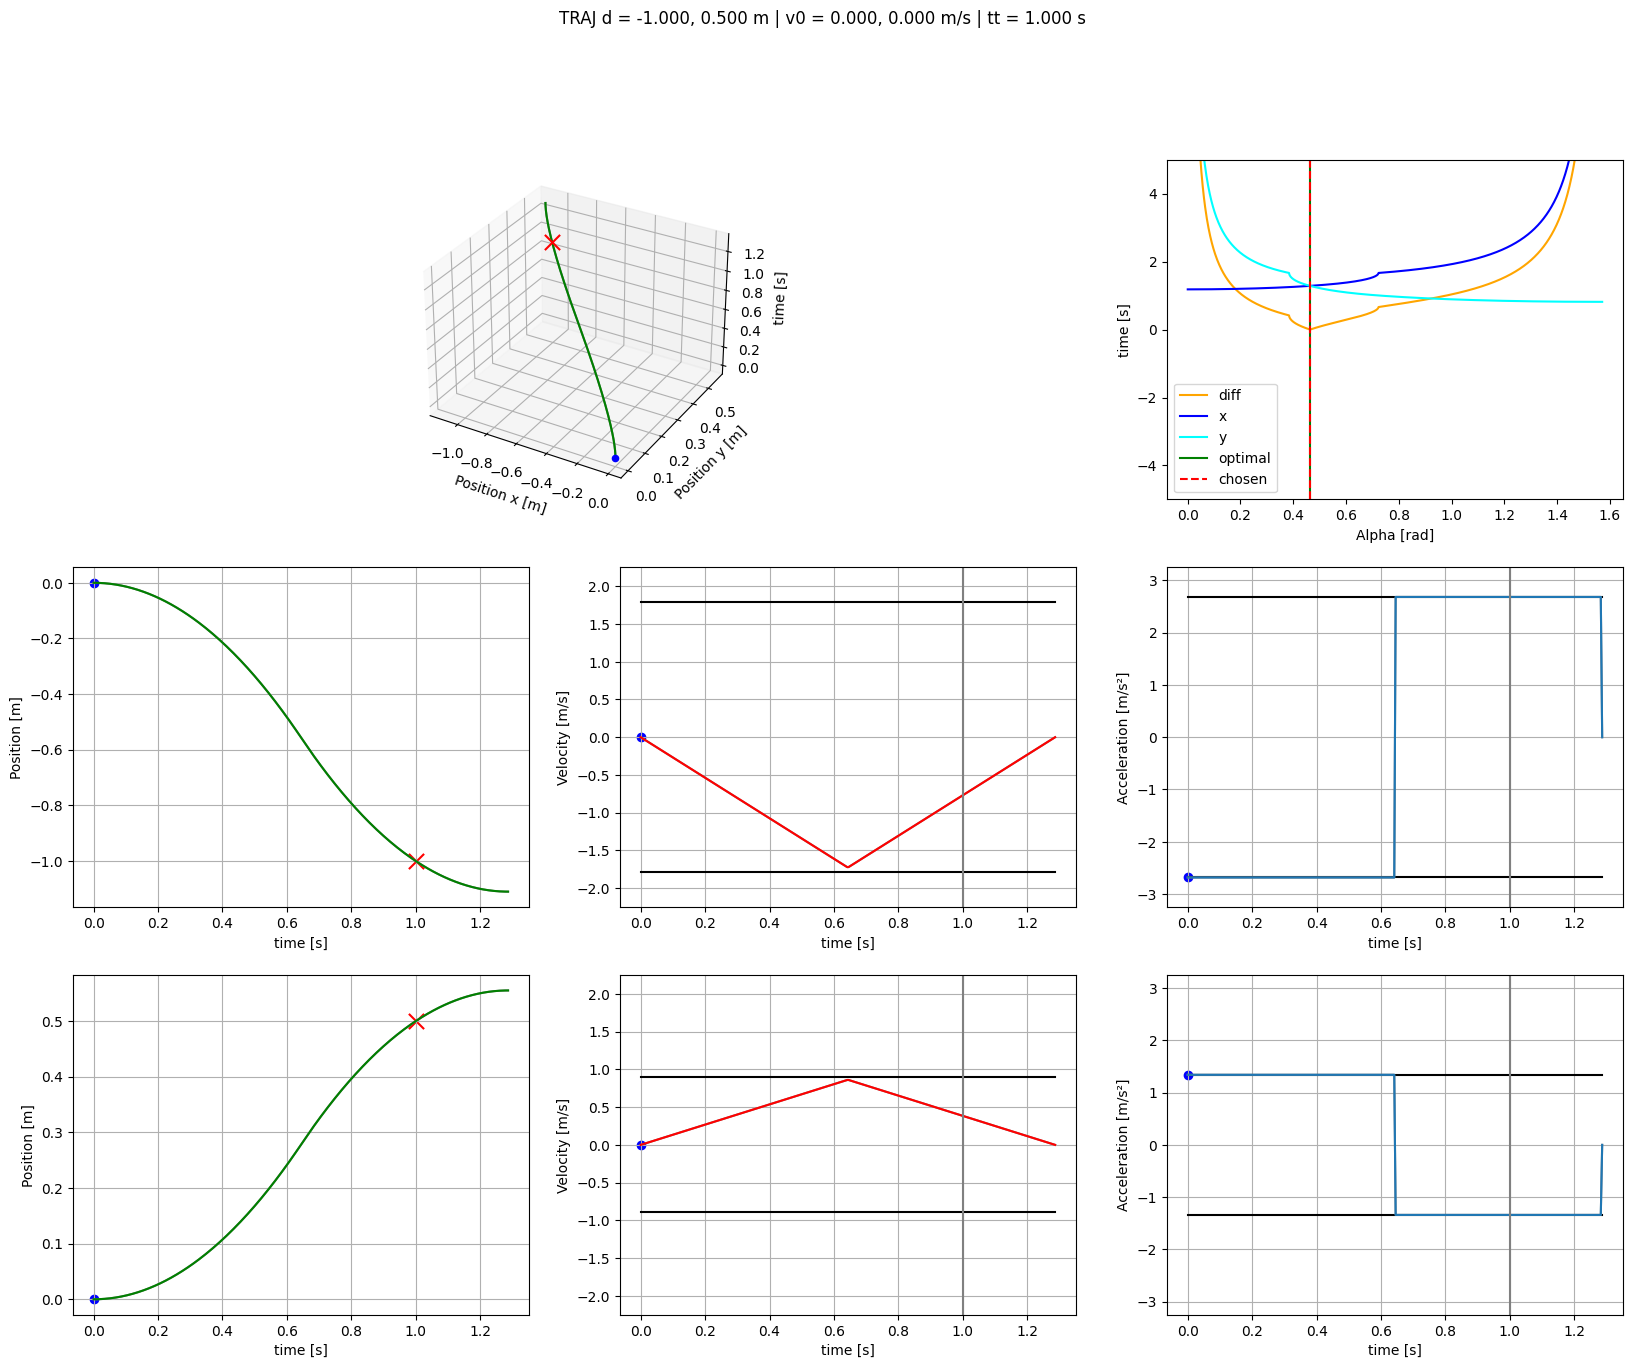

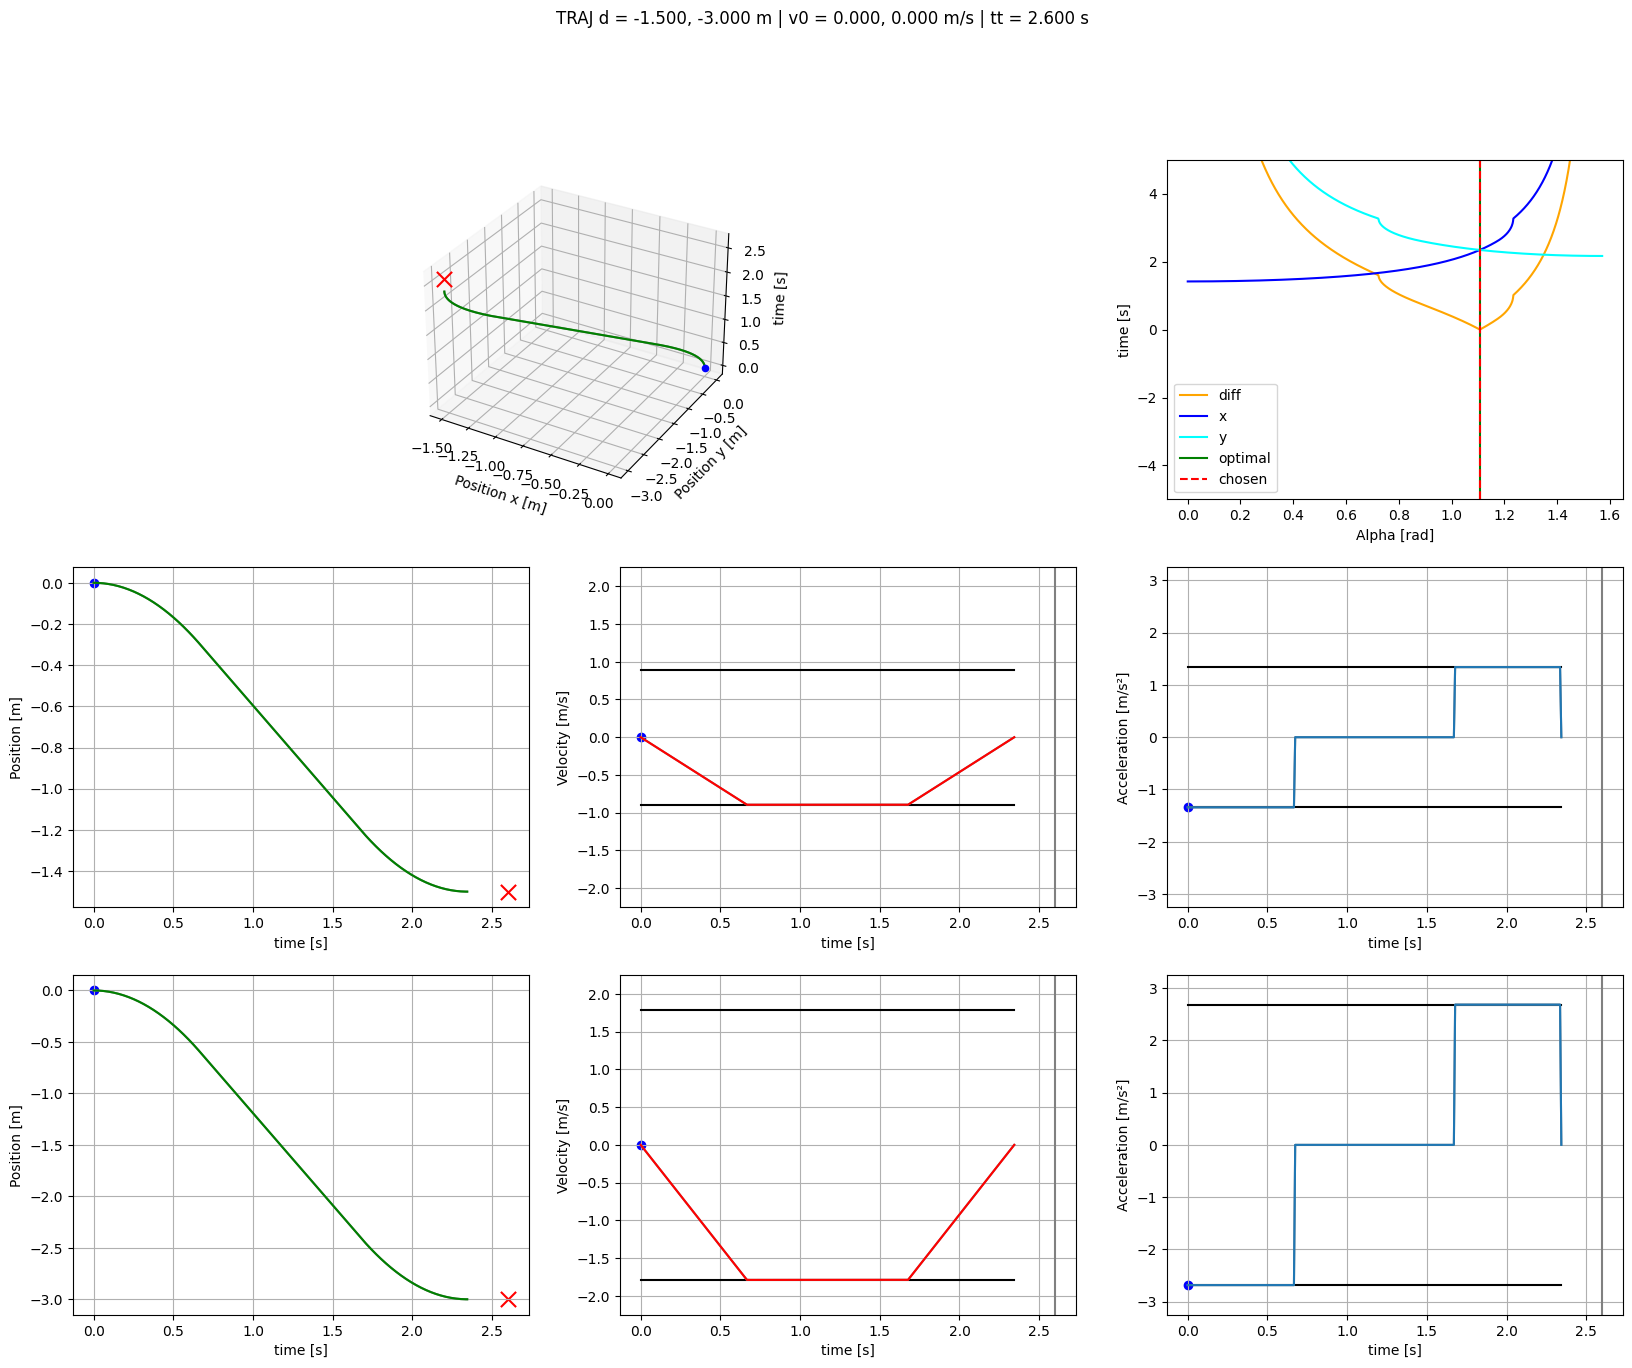

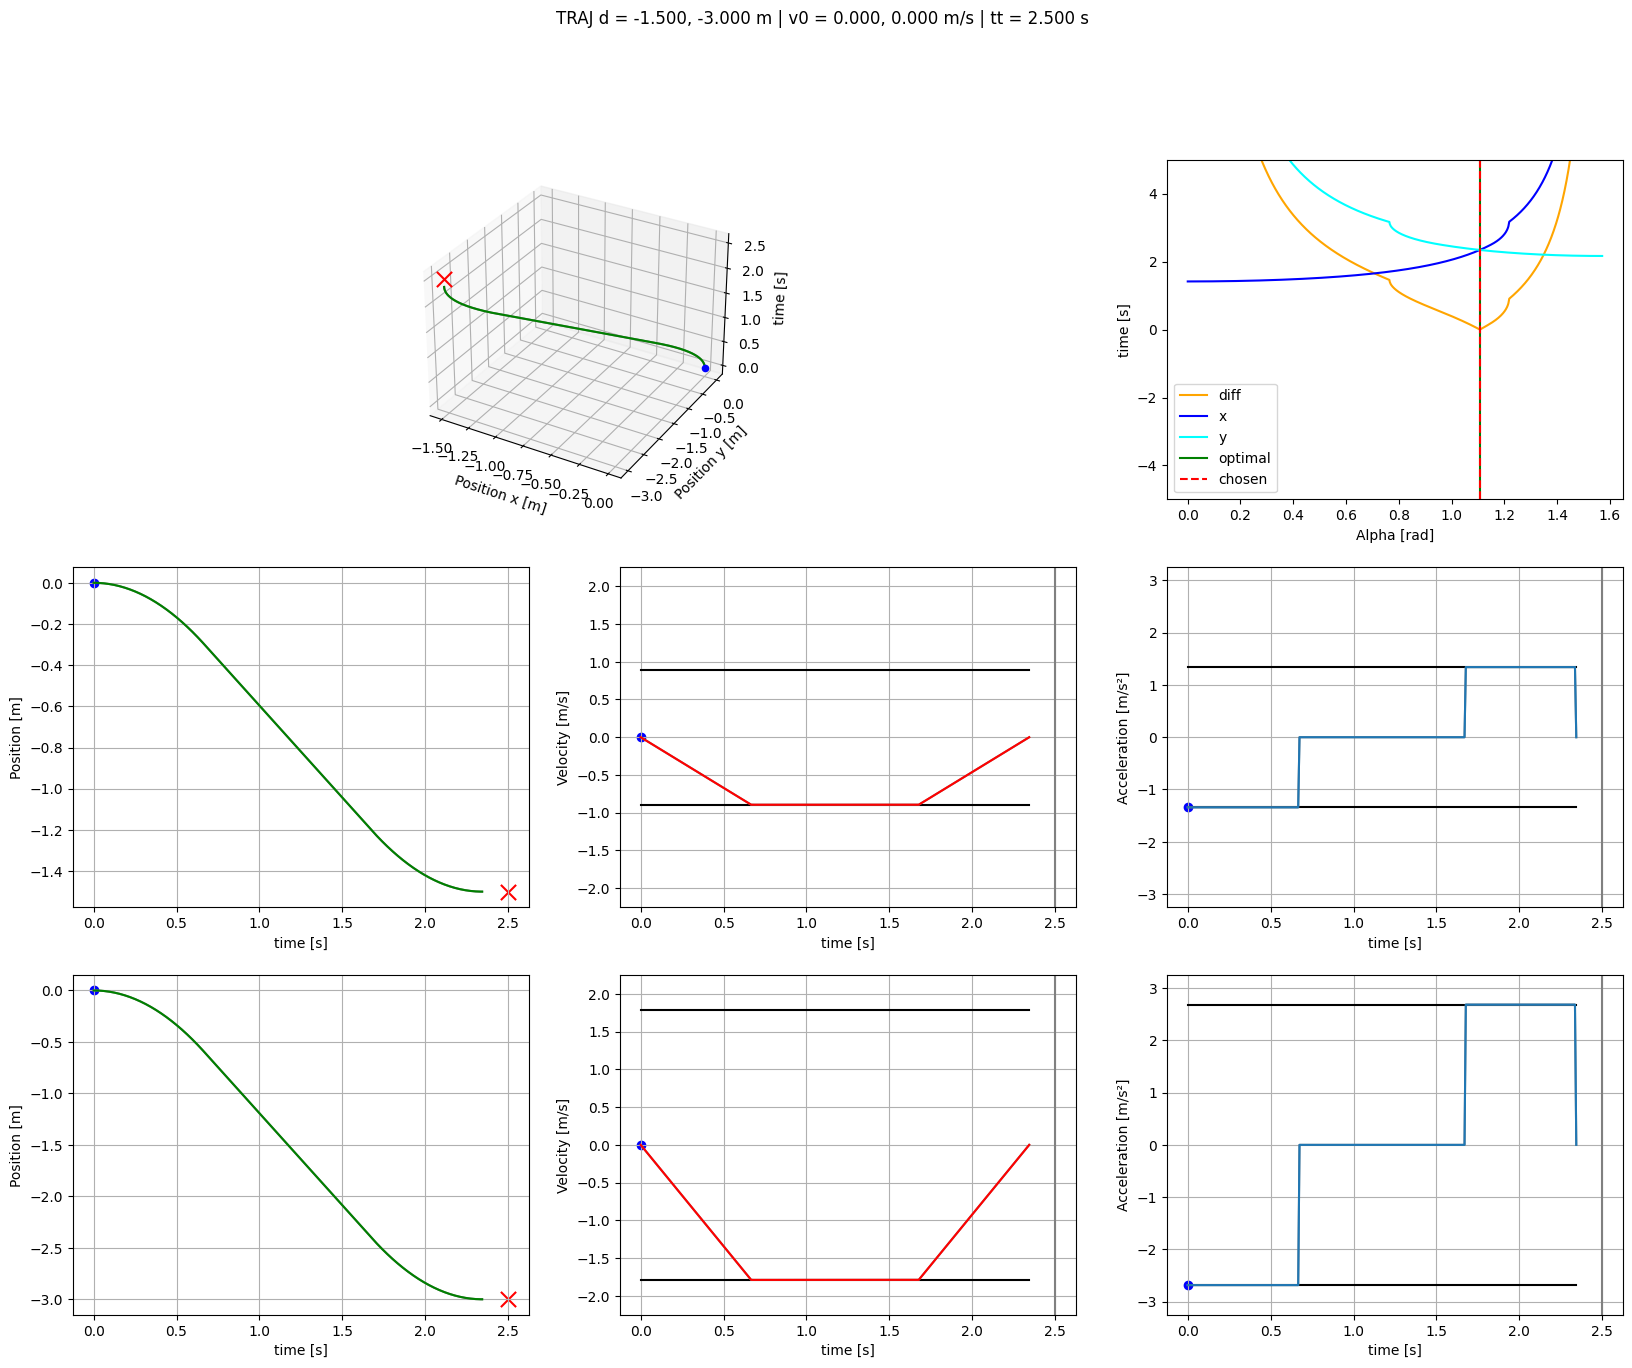

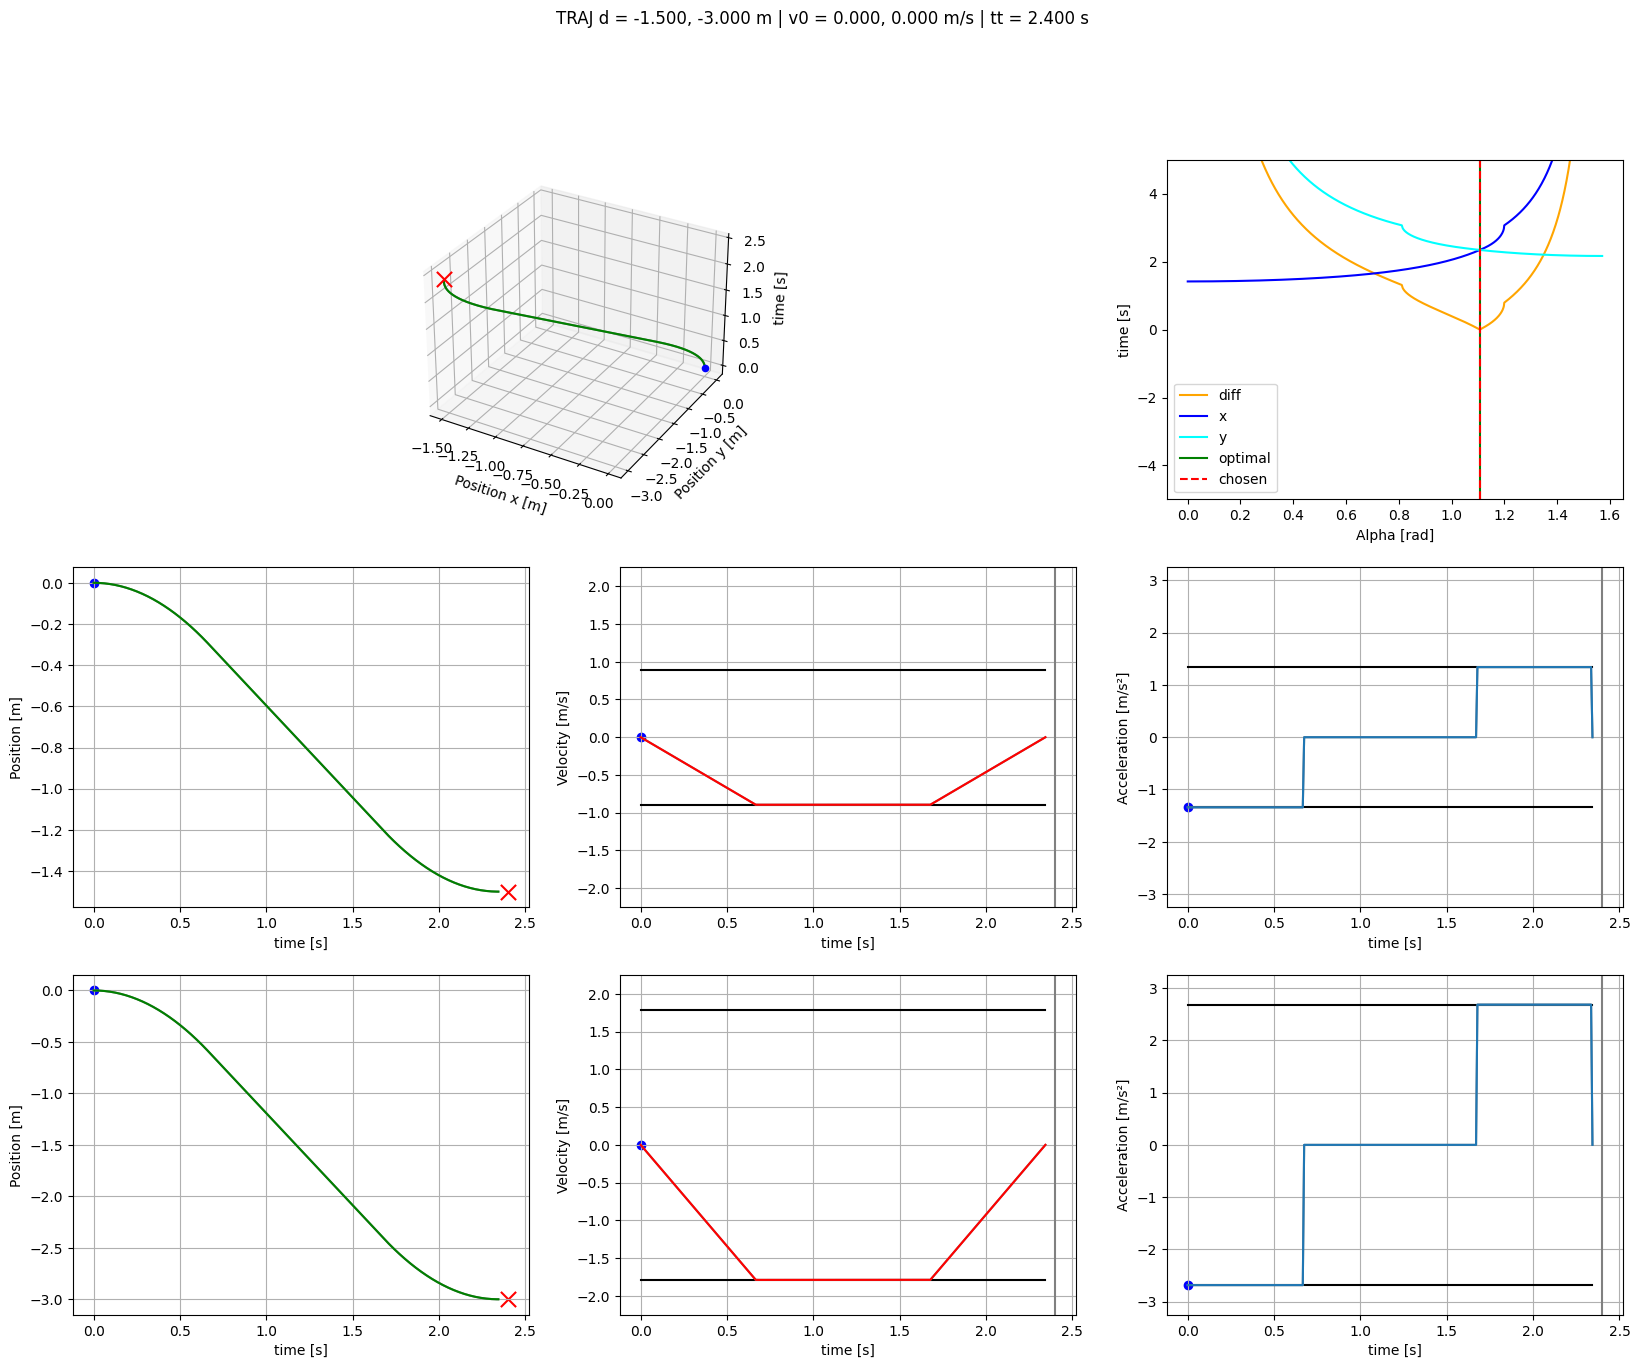

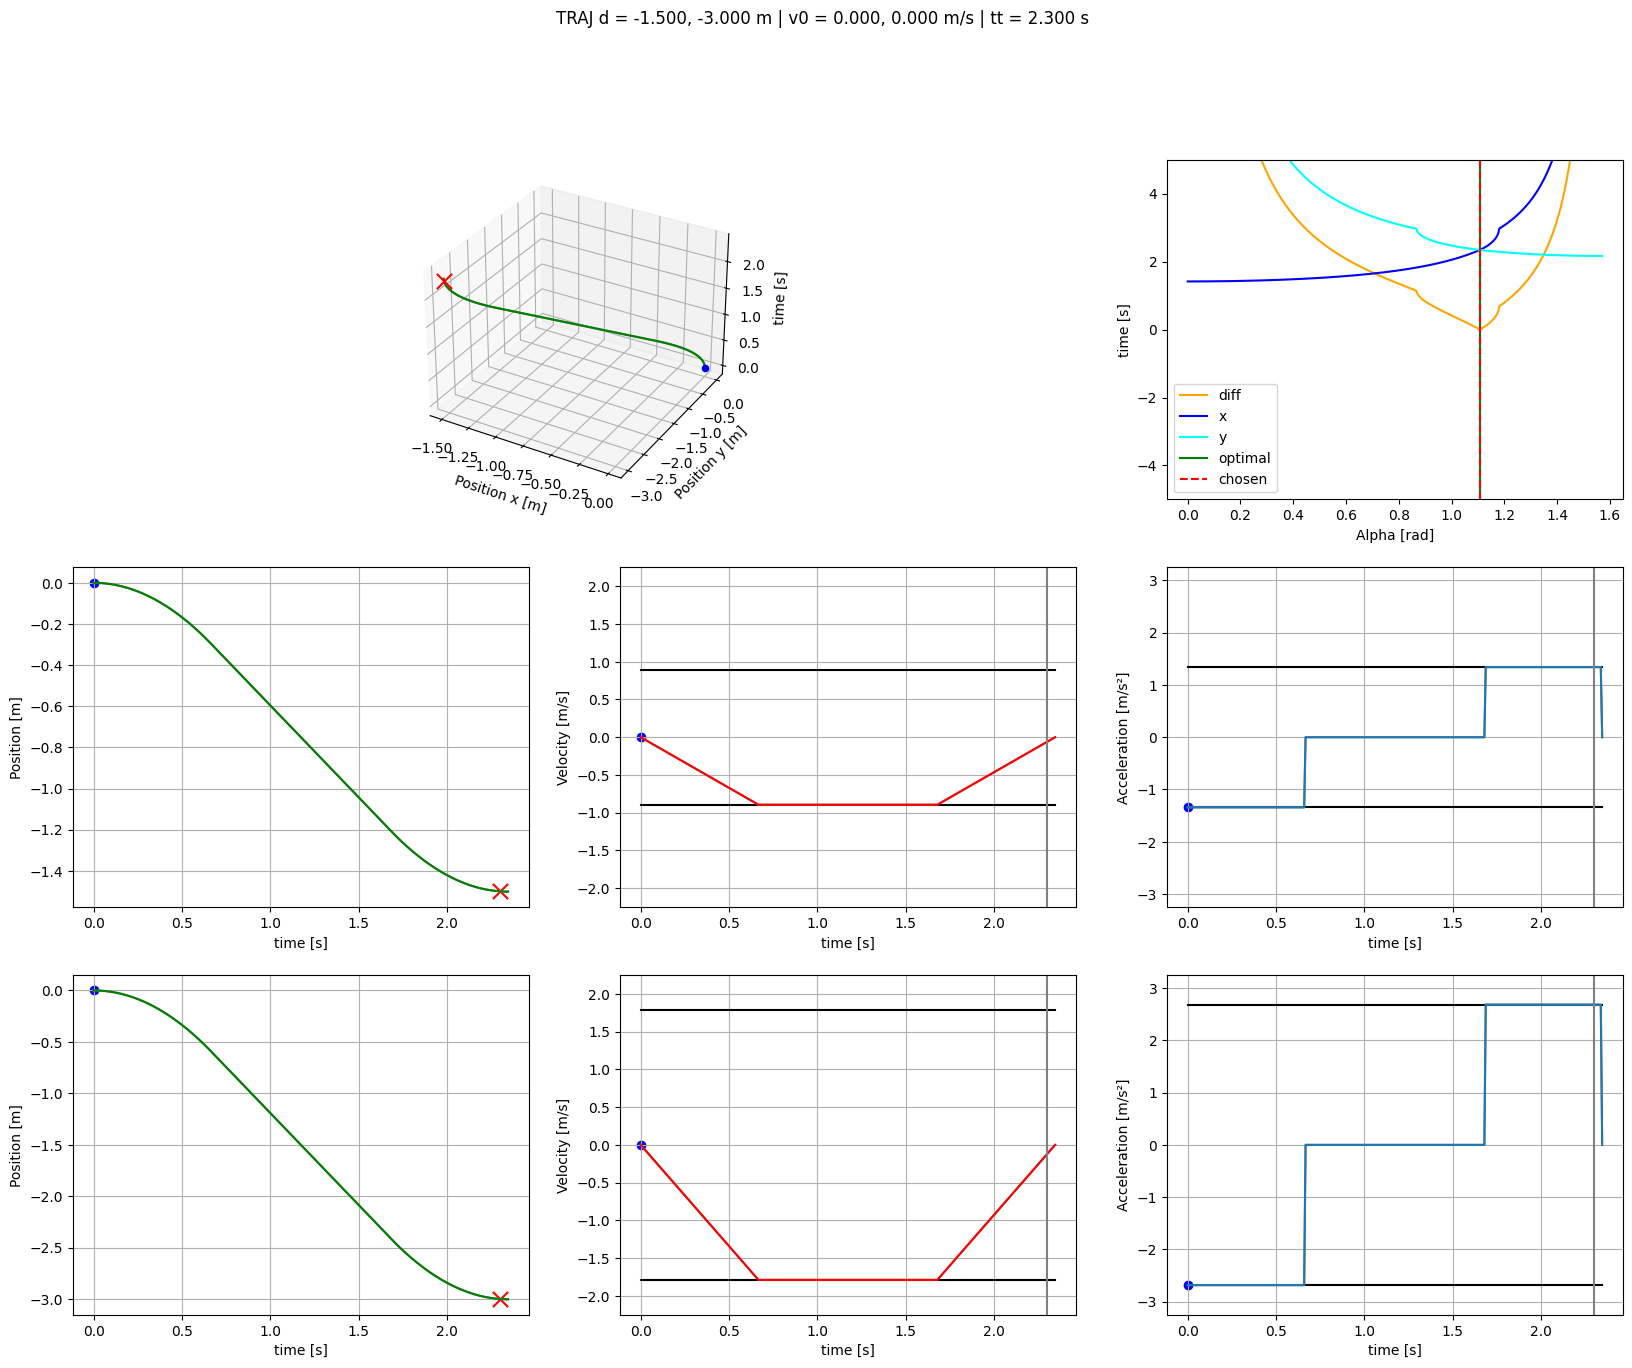

In [11]:
test_values = [
    ((-1.5, -3), (2, 0), 2.3),
    ((1, 0.5), (0, 0), 1),
    ((-1.5, -3), (0, 0), 2.2),
    ((-1, 0.5), (0, 0), 1),
    ((-1.5, -3), (0, 0), 2.6),
    ((-1.5, -3), (0, 0), 2.5),
    ((-1.5, -3), (0, 0), 2.4),
    ((-1.5, -3), (0, 0), 2.3),
]

for values in test_values:
    Plotter.plot(
        s0=0,
        s1=Vec2(*values[0]),
        v0=Vec2(*values[1]),
        v_max=v_max,
        a_max=a_max,
        tt=values[2],
        primary_direction=None,
        plot_type=PlotType.TRAJ,
        save_fig=False,
        show_fig=True
    )

In [10]:
random.seed(1)
t_diffs = []
t_outlier = []
for _ in range(100):
    distance_x = random.uniform(-3, 3)
    distance_y = random.uniform(-3, 3)
    distance = Vec2(distance_x, distance_y)
    v0x = random.uniform(-v_max, v_max)
    v0y = random.uniform(-v_max, v_max)
    v0 = Vec2(v0x, v0y)
    target_time = random.uniform(0, 3)

    if math.isclose(target_time, 0.0, abs_tol=1e-4) or (
            math.isclose(distance_x, 0.0, abs_tol=1e-4) and math.isclose(distance_y, 0.0, abs_tol=1e-4)):
        continue

    try:
        config = SimConfig(
            s=distance,
            v0=v0,
            tt=target_time,
            v_max=v_max,
            a_max=a_max,
        )
        sim_steps = Simulator().simulate(config, 40, 5)
        for step in sim_steps:
            if isinstance(step, SimStep2d):
                t_diff_optimal = step.alpha_data.optimal // (math.pi / (2 * len(step.alpha_data.alphas)))
                t_diff_chosen = step.alpha // (math.pi / (2 * len(step.alpha_data.alphas)))
                t_diffs.append(step.optimal_alpha - step.alpha)
                if abs(max(t_diff_chosen - t_diff_optimal, 0.0)) > 5:
                    Plotter.plot(step.current_pos(), distance, step.current_vel(), v_max, a_max,
                                 target_time - step.times[0], None, PlotType.TRAJ)
                    plt.show()
                    print("({}),({}),{}".format(step.pos[-1] - step.current_pos(), step.vel[0],
                                                step.times[-1] - step.times[0]))

        if isinstance(distance, Vec2):
            if not math.isclose(sim_steps[-1].current_pos().x, distance.x, abs_tol=0.01) or not math.isclose(
                    sim_steps[-1].current_pos().y, distance.y, abs_tol=0.01):
                print("{} != {}".format(sim_steps[-1].current_pos().x, distance.x))
                print("{} != {}".format(sim_steps[-1].current_pos().y, distance.y))
                # Plotter.plot(distance, v0, target_time, max_vel, max_acc, PlotType.TRAJ)
        else:
            assert math.isclose(sim_steps[-1].current_pos(), distance, abs_tol=1e-2,
                                rel_tol=1e-4), "{} != {}".format(sim_steps[-1].current_pos(), distance)
    except Exception as e:
        print("({}), ({}), {} failed".format(distance, v0, target_time))
        raise AssertionError(e)
print("Success!")
print("Alphas Error: {} +- {}".format(np.average(t_diffs), np.std(t_diffs)))

NameError: name 'max_vel' is not defined

In [ ]:
sorted(t_diffs, key=lambda d: abs(d))[-100:]